In [29]:
#%matplotlib notebook
import os
from datetime import datetime
from pathlib import Path
import math
import time
import numpy as np
import pandas as pd
from tabulate import tabulate
from matplotlib import pyplot as plt
import functools
import json

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import importlib
import plt_utils as pu
import evaluator as ev
import SMOTER as smtr
import forecasting_models as fmod
import relevance as rlv
import prepare_data as dprep
import GAN as gmod

#allows update import custom modules without having to restart kernel:
importlib.reload(pu)
importlib.reload(ev)
importlib.reload(smtr)
importlib.reload(fmod)
importlib.reload(rlv)
importlib.reload(dprep)
importlib.reload(gmod)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

LSTM imported successfully!


**Importing Data**

In [30]:
#If tvar and/or fvars not specified it'll just opt for the default specified by meta
def import_data(file_name, tvar=None, fvars=None):
    with open('data/meta.json','r') as file:
        meta = json.load(file)
    meta = meta[file_name]
    ds_name = meta['name']
    if file_name == 'london_merged.csv':
        #this dataset is multi-variate, can call this function with specified targets/features or just use defaults
        if not tvar: tvar = meta['tv']
        if not fvars: fvars = [tvar]
        df=pd.read_csv(f"data/{file_name}")
        df=df.reset_index()[fvars if tvar in fvars else [tvar] + fvars]
    else:
        #rest of the datasets are univariate and don't have headers
        tvar = meta['tv']
        fvars = [tvar]
        df=pd.read_csv(f"data/{file_name}", header=None, names=[tvar])
    return df, tvar, fvars, ds_name

#importing london_merged:
#DATA_FILE = 'london_merged.csv'
#df1, TVAR, FVARS, DATA_NAME = import_data(DATA_FILE)

#importing baseline:
DATA_FILE = 'sunspot.dat'
df1, TVAR, FVARS, DATA_NAME = import_data(DATA_FILE)

N_FVARS = len(FVARS)
print(df1)

      Sunspot Count
0               9.3
1               8.3
2               8.1
3               7.9
4               7.5
...             ...
2116            7.1
2117            7.6
2118            8.3
2119            9.3
2120           10.6

[2121 rows x 1 columns]


In [31]:
FORECASTERS = ["Conv_LSTM", "BD_LSTM"]

In [32]:
import recorder as rec
importlib.reload(rec)
to_save = {'forecast_models': False,
           'forecast_results': False,
           'resample_models': False, #best GANs 
           'resample_results': True,
           'eval_results': True, #evaluation metrics
           'logs': True,
           'figures': True,
           'parameters': True,
          }

RECORDER = rec.ExperimentRecorder(to_save, "Bike", FORECASTERS)
#LOADER = rec.ExperimentLoader(to_load, "Bike")
#load results from a previous session to compare with results from this session
#base_results_dir must contain resampling results and eval results to combine results
COMBINE_RESULTS_DIR = None #"Sessions/Bike/2023-October-13 13-41-03-532984"

#set GAN_DIR to none to train a new GAN, else give it a folder path to load from
GAN_CNN_DIR = None
GAN_FNN_DIR = None
#GAN_FNN_DIR = Path("C:\\Users\\jonny\\Documents\\RA\\EVF\\code\\thesis\\resampling\\Session Data\\2023-September-28 09-51-03-210656\\resample_models")

#set FORECAST_DIR to none to train a new LSTM, else give it a folder path to load from
FORECAST_DIR = None
#FORECAST_DIR = Path("C:\\Users\\jonny\\Documents\\RA\\EVF\\code\\thesis\\resampling\\Session Data\\2023-September-28 09-51-03-210656\\forecast_models")
loadedModels = {"loadedModels": {"GanCnnDir": GAN_CNN_DIR, "GanFnnDir":GAN_FNN_DIR, "ForecastDir": FORECAST_DIR}}
RECORDER.save_param_dict(loadedModels)

**Prepare Data for Resampling/Training**
* Split dataset into train and test split
* Convert data into Taken embedded time series format

In [33]:
RECORDER.log_print(f"Using data from: {DATA_FILE}")
RECORDER.log_print(f"Using feature variables: {FVARS} to predict target variable: '{TVAR}'")
RECORDER.save_param_dict({"importingData":{"dataFile":DATA_FILE,"targetVar":TVAR,"featVars":FVARS}})

df1 = np.array(df1).reshape(-1,N_FVARS)

scaler=MinMaxScaler(feature_range=(0,1))
df1 = df1.reshape(-1,N_FVARS)
scaled_data = scaler.fit_transform(df1) 
print(f"scaled_data: {scaled_data.shape}")

#Prep Data
N_STEPS_IN = 5
N_STEPS_OUT = 5
SPLIT_RATIO = 0.7
SAMPLE_DIM = N_STEPS_IN*N_FVARS + N_STEPS_OUT

k_X, X_train, Y_train, X_test, Y_test = dprep.split_data(scaled_data, N_STEPS_IN, N_STEPS_OUT, FVARS, N_FVARS, TVAR, SPLIT_RATIO)

RECORDER.save_param_dict({"prepData":{"nStepsIn":N_STEPS_IN,"nStepsOut":N_STEPS_OUT,"splitRatio":SPLIT_RATIO}})
RECORDER.log_print(f"Embedding steps in: {N_STEPS_IN} and steps out: {N_STEPS_OUT}")
RECORDER.log_print(f"Split dataset with training ratio: {SPLIT_RATIO}")
RECORDER.log_print(f"""Split data shapes:\n\t X_train: {X_train.shape}\n\t Y_train: {Y_train.shape}\n\t X_test: {X_test.shape}\n\t Y_test: {Y_test.shape}\n\t k_X: {k_X.shape}""")

LOG: 13:04:39:390 Using data from: sunspot.dat

LOG: 13:04:39:392 Using feature variables: ['Sunspot Count'] to predict target variable: 'Sunspot Count'

scaled_data: (2121, 1)
LOG: 13:04:39:437 Embedding steps in: 5 and steps out: 5

LOG: 13:04:39:437 Split dataset with training ratio: 0.7

LOG: 13:04:39:437 Split data shapes:
	 X_train: (1478, 5, 1)
	 Y_train: (1478, 5)
	 X_test: (634, 5, 1)
	 Y_test: (634, 5)
	 k_X: (1478, 10)


**Relevance**

In [34]:
#give this guy a list of training target values and it will give you a function that you can input target values to get a relevance score
def getPoisRelFunc(y):
    sample_mean = np.mean(y) 
    sample_std = np.std(y)
    rel_quant = np.quantile(1/rlv.dpois(y,sample_mean),0.5)
    RECORDER.save_param_dict({"relevanceFunc":{"funcName":"Pois","funcParams":{}}})
    return functools.partial(rlv.poisRelevance, smean=sample_mean, sstd=sample_std, rshift=rel_quant)
    
def getPCHIPRelFunc(y, percs, rels):
    pchip = rlv.PCHIP_interpolator(y, percs, rels)
    RECORDER.save_param_dict({"relevanceFunc":{"funcName":"PCHIP","funcParams":{"percentages":list(percs),"rels":list(rels)}}})
    return functools.partial(rlv.PCHIPRelevance, pchip_func=pchip)

all_train_targets = np.append(Y_train[:,0],Y_train[-1,1:]) 
#RELEVANCE_THRESHOLD = 0.31
#RELEVANCE_FUNCTION = getPoisRelFunc(all_train_targets)
RELEVANCE_THRESHOLD = 0.8
pchip_percentiles = [25,95,99]#[25,50,75,95,99]
pchip_relevances = [0.0,0.75,1.0]#[0.0,0.25,0.5,0.75,1.0]
RELEVANCE_FUNCTION = getPCHIPRelFunc(all_train_targets, pchip_percentiles, pchip_relevances) 
EXTREMES_THRESHOLD = rlv.PCHIPApproxInverse(RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION, 0, 0.99) #target value that intersects with RELEVANCE_THRESHOLD

COMBINE = 'first'
r_Y = RELEVANCE_FUNCTION.__call__(Y_train, combine=COMBINE)
k_Y = [val >= RELEVANCE_THRESHOLD for val in r_Y]

RECORDER.save_param_dict({"relevance":{"relThresh":RELEVANCE_THRESHOLD,"exThresh": EXTREMES_THRESHOLD}})

num_rel=k_Y.count(True)

RECORDER.log_print(f"Relevance function {RELEVANCE_FUNCTION.func.__name__} used with threshold: {RELEVANCE_THRESHOLD}")
RECORDER.log_print(f"Relevance {len(k_Y)-num_rel} common values, {num_rel} relevant values")

r_Y = np.array(r_Y)
k_Y = np.array(k_Y)
k_Xex = k_X[k_Y]
print(f"r_Y: {r_Y.shape}")
#print(r_Y)
print(f"k_Y: {k_Y.shape}")
#print(k_Y)
print(f"k_Xex: {k_Xex.shape}")

LOG: 13:04:47:230 Relevance function PCHIPRelevance used with threshold: 0.8

LOG: 13:04:47:231 Relevance 1417 common values, 61 relevant values

r_Y: (1478,)
k_Y: (1478,)
k_Xex: (61, 10)


***Plot Relevance Information***

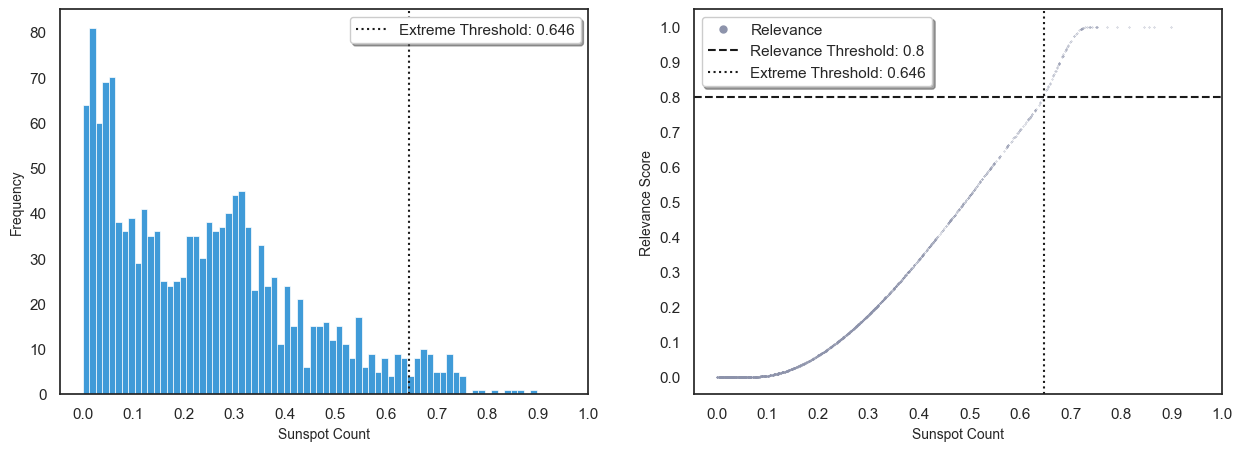

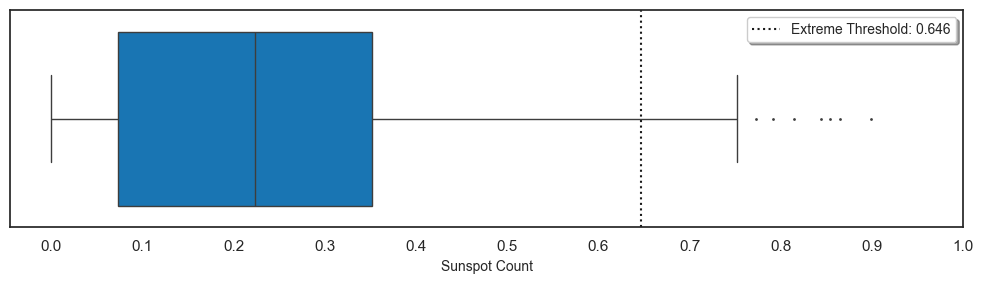

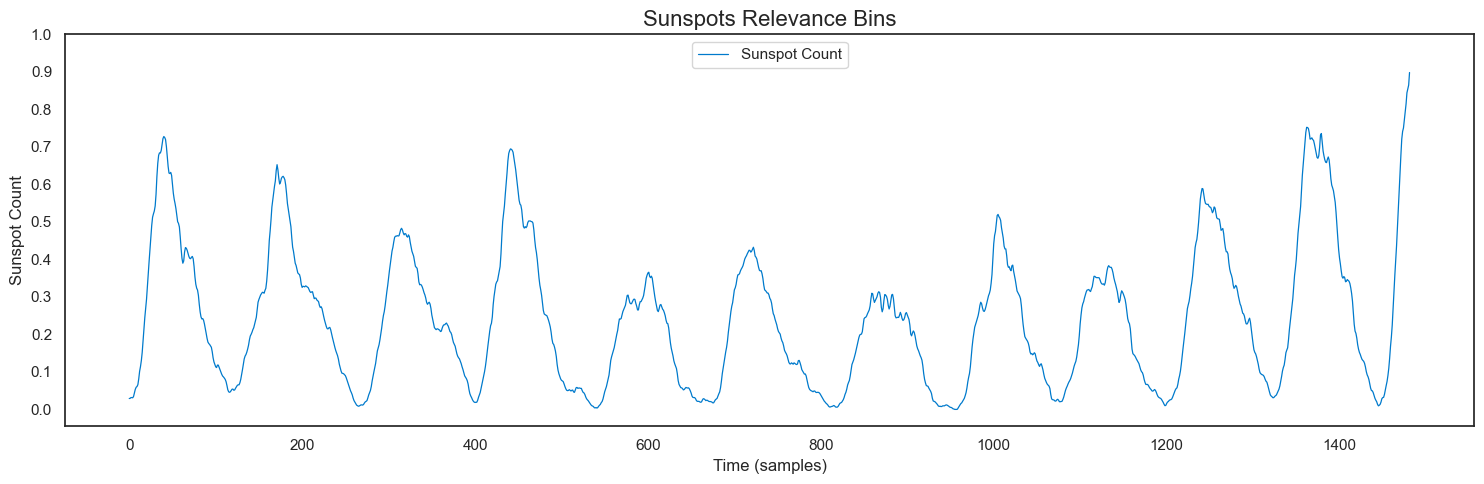

In [36]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)

#pu.PlotScaledData(data, TVAR)

r_Y_plot = RELEVANCE_FUNCTION.__call__(all_train_targets, combine=COMBINE) #relevance for plotting
k_Y_plot = [val >= RELEVANCE_THRESHOLD for val in r_Y_plot]
r_Y_plot = np.array(r_Y_plot)
k_Y_plot = np.array(k_Y_plot)

pu.PlotRelevance(all_train_targets, r_Y_plot, RELEVANCE_THRESHOLD, EXTREMES_THRESHOLD, TVAR, DATA_NAME)

#pu.PlotCaseWeightSurface(all_train_targets, RELEVANCE_FUNCTION, EXTREMES_THRESHOLD, 0.5, TVAR)
#pu.PlotUtilitySurface(all_train_targets, RELEVANCE_FUNCTION, EXTREMES_THRESHOLD, 0.5, TVAR)

pu.PlotBins(all_train_targets,k_Y_plot,EXTREMES_THRESHOLD, TVAR, DATA_NAME)
#pu.PlotBins(all_train_targets[3000:4000],k_Y_plot[3000:4000],EXTREMES_THRESHOLD, TVAR, DATA_NAME)



# **Resampling**

In [8]:
RES_STRATS = ["SMOTER_regular", "SMOTER_bin"]#, "SMOTER_bin_t", "SMOTER_bin_r", "SMOTER_bin_tr", "GAN_CNN", "GAN_FNN"]

**Define GAN Models**

In [9]:
import GAN as gmod
importlib.reload(gmod)

n_gan_epochs = 120
gan_batch_size = 128

CNN_GENS=None; CNN_DISCS=None; FNN_GENS=None; FNN_DISC=None

if "GAN_CNN" in RES_STRATS:
    CNN_GENS, CNN_DISCS = gmod.getGAN(k_Xex,GAN_CNN_DIR, "CNN", SAMPLE_DIM, n_gan_epochs, gan_batch_size, RECORDER.log_print)
if "GAN_FNN" in RES_STRATS:
    FNN_GENS, FNN_DISCS = gmod.getGAN(k_Xex,GAN_FNN_DIR, "FNN", SAMPLE_DIM, n_gan_epochs, gan_batch_size, RECORDER.log_print)

RECORDER.save_param_dict({"GAN":{"nEpochs":n_gan_epochs,"batchSize": gan_batch_size}})
print("$$$$ Finished training GANs $$$$")

LOG: 01:46:29:981 Training CNN GAN with 120 epochs


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Step 1: Generator loss: 1.4161276817321777, discriminator loss: 1.3887062072753906


  0%|          | 0/1 [00:00<?, ?it/s]

Step 2: Generator loss: 0.6822269558906555, discriminator loss: 0.6935408115386963


  0%|          | 0/1 [00:00<?, ?it/s]

Step 3: Generator loss: 0.666014552116394, discriminator loss: 0.6944577693939209


  0%|          | 0/1 [00:00<?, ?it/s]

Step 4: Generator loss: 0.6542338132858276, discriminator loss: 0.6948200464248657


  0%|          | 0/1 [00:00<?, ?it/s]

Step 5: Generator loss: 0.6458050012588501, discriminator loss: 0.6953115463256836


  0%|          | 0/1 [00:00<?, ?it/s]

Step 6: Generator loss: 0.6408191919326782, discriminator loss: 0.6960252523422241


  0%|          | 0/1 [00:00<?, ?it/s]

Step 7: Generator loss: 0.6395631432533264, discriminator loss: 0.696091890335083


  0%|          | 0/1 [00:00<?, ?it/s]

Step 8: Generator loss: 0.6405154466629028, discriminator loss: 0.6959290504455566


  0%|          | 0/1 [00:00<?, ?it/s]

Step 9: Generator loss: 0.6456732749938965, discriminator loss: 0.6953182220458984


  0%|          | 0/1 [00:00<?, ?it/s]

Step 10: Generator loss: 0.6506205797195435, discriminator loss: 0.6947134733200073


  0%|          | 0/1 [00:00<?, ?it/s]

Step 11: Generator loss: 0.6599273681640625, discriminator loss: 0.6932637691497803


  0%|          | 0/1 [00:00<?, ?it/s]

Step 12: Generator loss: 0.6698169112205505, discriminator loss: 0.6917836666107178


  0%|          | 0/1 [00:00<?, ?it/s]

Step 13: Generator loss: 0.6822986006736755, discriminator loss: 0.68975430727005


  0%|          | 0/1 [00:00<?, ?it/s]

Step 14: Generator loss: 0.6949794292449951, discriminator loss: 0.6881242990493774


  0%|          | 0/1 [00:00<?, ?it/s]

Step 15: Generator loss: 0.7102638483047485, discriminator loss: 0.6857149600982666


  0%|          | 0/1 [00:00<?, ?it/s]

Step 16: Generator loss: 0.7248631715774536, discriminator loss: 0.6833300590515137


  0%|          | 0/1 [00:00<?, ?it/s]

Step 17: Generator loss: 0.74052894115448, discriminator loss: 0.6806924343109131


  0%|          | 0/1 [00:00<?, ?it/s]

Step 18: Generator loss: 0.7573010325431824, discriminator loss: 0.6779564619064331


  0%|          | 0/1 [00:00<?, ?it/s]

Step 19: Generator loss: 0.7729330658912659, discriminator loss: 0.6756078004837036


  0%|          | 0/1 [00:00<?, ?it/s]

Step 20: Generator loss: 0.787797212600708, discriminator loss: 0.6736498475074768


  0%|          | 0/1 [00:00<?, ?it/s]

Step 21: Generator loss: 0.8020815849304199, discriminator loss: 0.6714668273925781


  0%|          | 0/1 [00:00<?, ?it/s]

Step 22: Generator loss: 0.8116164207458496, discriminator loss: 0.6701134443283081


  0%|          | 0/1 [00:00<?, ?it/s]

Step 23: Generator loss: 0.8202478289604187, discriminator loss: 0.6701961755752563


  0%|          | 0/1 [00:00<?, ?it/s]

Step 24: Generator loss: 0.8247326016426086, discriminator loss: 0.6700029373168945


  0%|          | 0/1 [00:00<?, ?it/s]

Step 25: Generator loss: 0.8282404541969299, discriminator loss: 0.6712251305580139


  0%|          | 0/1 [00:00<?, ?it/s]

Step 26: Generator loss: 0.8273900747299194, discriminator loss: 0.6730173826217651


  0%|          | 0/1 [00:00<?, ?it/s]

Step 27: Generator loss: 0.8249897360801697, discriminator loss: 0.6753256320953369


  0%|          | 0/1 [00:00<?, ?it/s]

Step 28: Generator loss: 0.8175745606422424, discriminator loss: 0.6777750253677368


  0%|          | 0/1 [00:00<?, ?it/s]

Step 29: Generator loss: 0.8156446218490601, discriminator loss: 0.6795880198478699


  0%|          | 0/1 [00:00<?, ?it/s]

Step 30: Generator loss: 0.812260627746582, discriminator loss: 0.6812728047370911


  0%|          | 0/1 [00:00<?, ?it/s]

Step 31: Generator loss: 0.8061841726303101, discriminator loss: 0.6832327246665955


  0%|          | 0/1 [00:00<?, ?it/s]

Step 32: Generator loss: 0.803527295589447, discriminator loss: 0.6841598749160767


  0%|          | 0/1 [00:00<?, ?it/s]

Step 33: Generator loss: 0.7995374798774719, discriminator loss: 0.6852470636367798


  0%|          | 0/1 [00:00<?, ?it/s]

Step 34: Generator loss: 0.7940457463264465, discriminator loss: 0.6862531900405884


  0%|          | 0/1 [00:00<?, ?it/s]

Step 35: Generator loss: 0.7878466248512268, discriminator loss: 0.6882513165473938


  0%|          | 0/1 [00:00<?, ?it/s]

Step 36: Generator loss: 0.7805169820785522, discriminator loss: 0.6902903318405151


  0%|          | 0/1 [00:00<?, ?it/s]

Step 37: Generator loss: 0.7676683664321899, discriminator loss: 0.6939082145690918


  0%|          | 0/1 [00:00<?, ?it/s]

Step 38: Generator loss: 0.7518349289894104, discriminator loss: 0.6978081464767456


  0%|          | 0/1 [00:00<?, ?it/s]

Step 39: Generator loss: 0.7358763217926025, discriminator loss: 0.7027912139892578


  0%|          | 0/1 [00:00<?, ?it/s]

Step 40: Generator loss: 0.7232927680015564, discriminator loss: 0.7080559730529785


  0%|          | 0/1 [00:00<?, ?it/s]

Step 41: Generator loss: 0.7060592770576477, discriminator loss: 0.7125722169876099


  0%|          | 0/1 [00:00<?, ?it/s]

Step 42: Generator loss: 0.691125750541687, discriminator loss: 0.7171245813369751


  0%|          | 0/1 [00:00<?, ?it/s]

Step 43: Generator loss: 0.6829083561897278, discriminator loss: 0.7190173864364624


  0%|          | 0/1 [00:00<?, ?it/s]

Step 44: Generator loss: 0.6746832132339478, discriminator loss: 0.7198089361190796


  0%|          | 0/1 [00:00<?, ?it/s]

Step 45: Generator loss: 0.670032799243927, discriminator loss: 0.7188683748245239


  0%|          | 0/1 [00:00<?, ?it/s]

Step 46: Generator loss: 0.668184757232666, discriminator loss: 0.7144104242324829


  0%|          | 0/1 [00:00<?, ?it/s]

Step 47: Generator loss: 0.6706591844558716, discriminator loss: 0.7097975015640259


  0%|          | 0/1 [00:00<?, ?it/s]

Step 48: Generator loss: 0.673835039138794, discriminator loss: 0.7033807039260864


  0%|          | 0/1 [00:00<?, ?it/s]

Step 49: Generator loss: 0.6786082983016968, discriminator loss: 0.6958028674125671


  0%|          | 0/1 [00:00<?, ?it/s]

Step 50: Generator loss: 0.6845145225524902, discriminator loss: 0.6876643896102905


  0%|          | 0/1 [00:00<?, ?it/s]

Step 51: Generator loss: 0.6915856003761292, discriminator loss: 0.679088294506073


  0%|          | 0/1 [00:00<?, ?it/s]

Step 52: Generator loss: 0.6999374628067017, discriminator loss: 0.6697750091552734


  0%|          | 0/1 [00:00<?, ?it/s]

Step 53: Generator loss: 0.7055915594100952, discriminator loss: 0.6614314317703247


  0%|          | 0/1 [00:00<?, ?it/s]

Step 54: Generator loss: 0.7114651799201965, discriminator loss: 0.653840184211731


  0%|          | 0/1 [00:00<?, ?it/s]

Step 55: Generator loss: 0.7163001298904419, discriminator loss: 0.6461305618286133


  0%|          | 0/1 [00:00<?, ?it/s]

Step 56: Generator loss: 0.7166641354560852, discriminator loss: 0.6408652067184448


  0%|          | 0/1 [00:00<?, ?it/s]

Step 57: Generator loss: 0.7175798416137695, discriminator loss: 0.636772632598877


  0%|          | 0/1 [00:00<?, ?it/s]

Step 58: Generator loss: 0.7150886654853821, discriminator loss: 0.632765531539917


  0%|          | 0/1 [00:00<?, ?it/s]

Step 59: Generator loss: 0.7096724510192871, discriminator loss: 0.6306650638580322


  0%|          | 0/1 [00:00<?, ?it/s]

Step 60: Generator loss: 0.7075070142745972, discriminator loss: 0.627959132194519


  0%|          | 0/1 [00:00<?, ?it/s]

Step 61: Generator loss: 0.7017700672149658, discriminator loss: 0.6265107989311218


  0%|          | 0/1 [00:00<?, ?it/s]

Step 62: Generator loss: 0.7020514011383057, discriminator loss: 0.6238861083984375


  0%|          | 0/1 [00:00<?, ?it/s]

Step 63: Generator loss: 0.6996581554412842, discriminator loss: 0.6218701601028442


  0%|          | 0/1 [00:00<?, ?it/s]

Step 64: Generator loss: 0.6983217597007751, discriminator loss: 0.620282769203186


  0%|          | 0/1 [00:00<?, ?it/s]

Step 65: Generator loss: 0.7003440260887146, discriminator loss: 0.6175367832183838


  0%|          | 0/1 [00:00<?, ?it/s]

Step 66: Generator loss: 0.7002546787261963, discriminator loss: 0.6139243841171265


  0%|          | 0/1 [00:00<?, ?it/s]

Step 67: Generator loss: 0.7071419358253479, discriminator loss: 0.6098827123641968


  0%|          | 0/1 [00:00<?, ?it/s]

Step 68: Generator loss: 0.7125731706619263, discriminator loss: 0.6044754981994629


  0%|          | 0/1 [00:00<?, ?it/s]

Step 69: Generator loss: 0.7211703062057495, discriminator loss: 0.5980880260467529


  0%|          | 0/1 [00:00<?, ?it/s]

Step 70: Generator loss: 0.73170006275177, discriminator loss: 0.5917041897773743


  0%|          | 0/1 [00:00<?, ?it/s]

Step 71: Generator loss: 0.7418608069419861, discriminator loss: 0.5854882001876831


  0%|          | 0/1 [00:00<?, ?it/s]

Step 72: Generator loss: 0.7498101592063904, discriminator loss: 0.5791550874710083


  0%|          | 0/1 [00:00<?, ?it/s]

Step 73: Generator loss: 0.7580764293670654, discriminator loss: 0.5749876499176025


  0%|          | 0/1 [00:00<?, ?it/s]

Step 74: Generator loss: 0.7591531872749329, discriminator loss: 0.5714108347892761


  0%|          | 0/1 [00:00<?, ?it/s]

Step 75: Generator loss: 0.7636871337890625, discriminator loss: 0.5684092044830322


  0%|          | 0/1 [00:00<?, ?it/s]

Step 76: Generator loss: 0.7663102746009827, discriminator loss: 0.565833330154419


  0%|          | 0/1 [00:00<?, ?it/s]

Step 77: Generator loss: 0.7675932049751282, discriminator loss: 0.5632734894752502


  0%|          | 0/1 [00:00<?, ?it/s]

Step 78: Generator loss: 0.7715703248977661, discriminator loss: 0.5602434873580933


  0%|          | 0/1 [00:00<?, ?it/s]

Step 79: Generator loss: 0.7821311354637146, discriminator loss: 0.554973304271698


  0%|          | 0/1 [00:00<?, ?it/s]

Step 80: Generator loss: 0.7918437719345093, discriminator loss: 0.5488494038581848


  0%|          | 0/1 [00:00<?, ?it/s]

Step 81: Generator loss: 0.809124231338501, discriminator loss: 0.5419930815696716


  0%|          | 0/1 [00:00<?, ?it/s]

Step 82: Generator loss: 0.8252822160720825, discriminator loss: 0.533913254737854


  0%|          | 0/1 [00:00<?, ?it/s]

Step 83: Generator loss: 0.8444263339042664, discriminator loss: 0.5255573987960815


  0%|          | 0/1 [00:00<?, ?it/s]

Step 84: Generator loss: 0.8639433979988098, discriminator loss: 0.5172359943389893


  0%|          | 0/1 [00:00<?, ?it/s]

Step 85: Generator loss: 0.8841332793235779, discriminator loss: 0.5088075399398804


  0%|          | 0/1 [00:00<?, ?it/s]

Step 86: Generator loss: 0.9044954180717468, discriminator loss: 0.5005155205726624


  0%|          | 0/1 [00:00<?, ?it/s]

Step 87: Generator loss: 0.9246602058410645, discriminator loss: 0.4922991394996643


  0%|          | 0/1 [00:00<?, ?it/s]

Step 88: Generator loss: 0.9445531368255615, discriminator loss: 0.48422178626060486


  0%|          | 0/1 [00:00<?, ?it/s]

Step 89: Generator loss: 0.9640227556228638, discriminator loss: 0.47655850648880005


  0%|          | 0/1 [00:00<?, ?it/s]

Step 90: Generator loss: 0.9830638766288757, discriminator loss: 0.46916741132736206


  0%|          | 0/1 [00:00<?, ?it/s]

Step 91: Generator loss: 0.9993910789489746, discriminator loss: 0.4622955322265625


  0%|          | 0/1 [00:00<?, ?it/s]

Step 92: Generator loss: 1.0147991180419922, discriminator loss: 0.45565181970596313


  0%|          | 0/1 [00:00<?, ?it/s]

Step 93: Generator loss: 1.0272083282470703, discriminator loss: 0.45040905475616455


  0%|          | 0/1 [00:00<?, ?it/s]

Step 94: Generator loss: 1.035123348236084, discriminator loss: 0.44499093294143677


  0%|          | 0/1 [00:00<?, ?it/s]

Step 95: Generator loss: 1.0399258136749268, discriminator loss: 0.44164130091667175


  0%|          | 0/1 [00:00<?, ?it/s]

Step 96: Generator loss: 1.0397350788116455, discriminator loss: 0.4391009211540222


  0%|          | 0/1 [00:00<?, ?it/s]

Step 97: Generator loss: 1.0390042066574097, discriminator loss: 0.437777578830719


  0%|          | 0/1 [00:00<?, ?it/s]

Step 98: Generator loss: 1.0384018421173096, discriminator loss: 0.43533873558044434


  0%|          | 0/1 [00:00<?, ?it/s]

Step 99: Generator loss: 1.0378347635269165, discriminator loss: 0.4327583611011505


  0%|          | 0/1 [00:00<?, ?it/s]

Step 100: Generator loss: 1.0432053804397583, discriminator loss: 0.4282063841819763


  0%|          | 0/1 [00:00<?, ?it/s]

Step 101: Generator loss: 1.0511358976364136, discriminator loss: 0.42371323704719543


  0%|          | 0/1 [00:00<?, ?it/s]

Step 102: Generator loss: 1.0613675117492676, discriminator loss: 0.4180248975753784


  0%|          | 0/1 [00:00<?, ?it/s]

Step 103: Generator loss: 1.0746433734893799, discriminator loss: 0.41217175126075745


  0%|          | 0/1 [00:00<?, ?it/s]

Step 104: Generator loss: 1.0874407291412354, discriminator loss: 0.4059241712093353


  0%|          | 0/1 [00:00<?, ?it/s]

Step 105: Generator loss: 1.102503776550293, discriminator loss: 0.39991331100463867


  0%|          | 0/1 [00:00<?, ?it/s]

Step 106: Generator loss: 1.1151397228240967, discriminator loss: 0.39379531145095825


  0%|          | 0/1 [00:00<?, ?it/s]

Step 107: Generator loss: 1.129460096359253, discriminator loss: 0.38791871070861816


  0%|          | 0/1 [00:00<?, ?it/s]

Step 108: Generator loss: 1.1413085460662842, discriminator loss: 0.38272082805633545


  0%|          | 0/1 [00:00<?, ?it/s]

Step 109: Generator loss: 1.152722716331482, discriminator loss: 0.3777310252189636


  0%|          | 0/1 [00:00<?, ?it/s]

Step 110: Generator loss: 1.1577396392822266, discriminator loss: 0.37367188930511475


  0%|          | 0/1 [00:00<?, ?it/s]

Step 111: Generator loss: 1.1591616868972778, discriminator loss: 0.3703271150588989


  0%|          | 0/1 [00:00<?, ?it/s]

Step 112: Generator loss: 1.1525241136550903, discriminator loss: 0.36971691250801086


  0%|          | 0/1 [00:00<?, ?it/s]

Step 113: Generator loss: 1.1344813108444214, discriminator loss: 0.3725880980491638


  0%|          | 0/1 [00:00<?, ?it/s]

Step 114: Generator loss: 1.1035603284835815, discriminator loss: 0.37731868028640747


  0%|          | 0/1 [00:00<?, ?it/s]

Step 115: Generator loss: 1.0470200777053833, discriminator loss: 0.38932597637176514


  0%|          | 0/1 [00:00<?, ?it/s]

Step 116: Generator loss: 0.9993172883987427, discriminator loss: 0.40301504731178284


  0%|          | 0/1 [00:00<?, ?it/s]

Step 117: Generator loss: 0.9269188642501831, discriminator loss: 0.4241238534450531


  0%|          | 0/1 [00:00<?, ?it/s]

Step 118: Generator loss: 0.8613672852516174, discriminator loss: 0.4452914595603943


  0%|          | 0/1 [00:00<?, ?it/s]

Step 119: Generator loss: 0.7933710813522339, discriminator loss: 0.47176164388656616
LOG: 01:47:56:570 Training FNN GAN with 120 epochs


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Step 1: Generator loss: 1.2934685945510864, discriminator loss: 1.38630610704422


  0%|          | 0/1 [00:00<?, ?it/s]

Step 2: Generator loss: 0.6461725234985352, discriminator loss: 0.6928595304489136


  0%|          | 0/1 [00:00<?, ?it/s]

Step 3: Generator loss: 0.6458402276039124, discriminator loss: 0.692702054977417


  0%|          | 0/1 [00:00<?, ?it/s]

Step 4: Generator loss: 0.6454010605812073, discriminator loss: 0.6924804449081421


  0%|          | 0/1 [00:00<?, ?it/s]

Step 5: Generator loss: 0.6450897455215454, discriminator loss: 0.6923869848251343


  0%|          | 0/1 [00:00<?, ?it/s]

Step 6: Generator loss: 0.6447539329528809, discriminator loss: 0.6921918988227844


  0%|          | 0/1 [00:00<?, ?it/s]

Step 7: Generator loss: 0.6443324685096741, discriminator loss: 0.6919823884963989


  0%|          | 0/1 [00:00<?, ?it/s]

Step 8: Generator loss: 0.6439794301986694, discriminator loss: 0.6918700337409973


  0%|          | 0/1 [00:00<?, ?it/s]

Step 9: Generator loss: 0.6436517238616943, discriminator loss: 0.691733717918396


  0%|          | 0/1 [00:00<?, ?it/s]

Step 10: Generator loss: 0.6434369087219238, discriminator loss: 0.6915954351425171


  0%|          | 0/1 [00:00<?, ?it/s]

Step 11: Generator loss: 0.6431514620780945, discriminator loss: 0.6914377212524414


  0%|          | 0/1 [00:00<?, ?it/s]

Step 12: Generator loss: 0.642815351486206, discriminator loss: 0.6912548542022705


  0%|          | 0/1 [00:00<?, ?it/s]

Step 13: Generator loss: 0.642515242099762, discriminator loss: 0.6911107301712036


  0%|          | 0/1 [00:00<?, ?it/s]

Step 14: Generator loss: 0.6421651244163513, discriminator loss: 0.6910697221755981


  0%|          | 0/1 [00:00<?, ?it/s]

Step 15: Generator loss: 0.6419912576675415, discriminator loss: 0.6908577680587769


  0%|          | 0/1 [00:00<?, ?it/s]

Step 16: Generator loss: 0.6416800618171692, discriminator loss: 0.6907293796539307


  0%|          | 0/1 [00:00<?, ?it/s]

Step 17: Generator loss: 0.6414762139320374, discriminator loss: 0.6906248331069946


  0%|          | 0/1 [00:00<?, ?it/s]

Step 18: Generator loss: 0.6410811543464661, discriminator loss: 0.6905210018157959


  0%|          | 0/1 [00:00<?, ?it/s]

Step 19: Generator loss: 0.6408286094665527, discriminator loss: 0.6903755068778992


  0%|          | 0/1 [00:00<?, ?it/s]

Step 20: Generator loss: 0.6405208706855774, discriminator loss: 0.690304696559906


  0%|          | 0/1 [00:00<?, ?it/s]

Step 21: Generator loss: 0.6402784585952759, discriminator loss: 0.6901975870132446


  0%|          | 0/1 [00:00<?, ?it/s]

Step 22: Generator loss: 0.6397719383239746, discriminator loss: 0.6900821328163147


  0%|          | 0/1 [00:00<?, ?it/s]

Step 23: Generator loss: 0.6396298408508301, discriminator loss: 0.6899367570877075


  0%|          | 0/1 [00:00<?, ?it/s]

Step 24: Generator loss: 0.6392013430595398, discriminator loss: 0.6898601055145264


  0%|          | 0/1 [00:00<?, ?it/s]

Step 25: Generator loss: 0.6388358473777771, discriminator loss: 0.6897050142288208


  0%|          | 0/1 [00:00<?, ?it/s]

Step 26: Generator loss: 0.6385592818260193, discriminator loss: 0.6896437406539917


  0%|          | 0/1 [00:00<?, ?it/s]

Step 27: Generator loss: 0.6381715536117554, discriminator loss: 0.689476490020752


  0%|          | 0/1 [00:00<?, ?it/s]

Step 28: Generator loss: 0.6378650069236755, discriminator loss: 0.6894122958183289


  0%|          | 0/1 [00:00<?, ?it/s]

Step 29: Generator loss: 0.6375553011894226, discriminator loss: 0.6893414258956909


  0%|          | 0/1 [00:00<?, ?it/s]

Step 30: Generator loss: 0.6371636986732483, discriminator loss: 0.689240574836731


  0%|          | 0/1 [00:00<?, ?it/s]

Step 31: Generator loss: 0.6367946863174438, discriminator loss: 0.6891833543777466


  0%|          | 0/1 [00:00<?, ?it/s]

Step 32: Generator loss: 0.6364229321479797, discriminator loss: 0.6890569925308228


  0%|          | 0/1 [00:00<?, ?it/s]

Step 33: Generator loss: 0.6361962556838989, discriminator loss: 0.6889463663101196


  0%|          | 0/1 [00:00<?, ?it/s]

Step 34: Generator loss: 0.6357919573783875, discriminator loss: 0.6888811588287354


  0%|          | 0/1 [00:00<?, ?it/s]

Step 35: Generator loss: 0.6355450749397278, discriminator loss: 0.688766360282898


  0%|          | 0/1 [00:00<?, ?it/s]

Step 36: Generator loss: 0.6352155804634094, discriminator loss: 0.6886419653892517


  0%|          | 0/1 [00:00<?, ?it/s]

Step 37: Generator loss: 0.634964108467102, discriminator loss: 0.688637912273407


  0%|          | 0/1 [00:00<?, ?it/s]

Step 38: Generator loss: 0.6347097158432007, discriminator loss: 0.6884968280792236


  0%|          | 0/1 [00:00<?, ?it/s]

Step 39: Generator loss: 0.6343231201171875, discriminator loss: 0.6883323192596436


  0%|          | 0/1 [00:00<?, ?it/s]

Step 40: Generator loss: 0.6340845823287964, discriminator loss: 0.6882670521736145


  0%|          | 0/1 [00:00<?, ?it/s]

Step 41: Generator loss: 0.6337146162986755, discriminator loss: 0.6883131265640259


  0%|          | 0/1 [00:00<?, ?it/s]

Step 42: Generator loss: 0.6333764791488647, discriminator loss: 0.6881294250488281


  0%|          | 0/1 [00:00<?, ?it/s]

Step 43: Generator loss: 0.6331496834754944, discriminator loss: 0.688080906867981


  0%|          | 0/1 [00:00<?, ?it/s]

Step 44: Generator loss: 0.6327924728393555, discriminator loss: 0.687926173210144


  0%|          | 0/1 [00:00<?, ?it/s]

Step 45: Generator loss: 0.6325942277908325, discriminator loss: 0.6879706978797913


  0%|          | 0/1 [00:00<?, ?it/s]

Step 46: Generator loss: 0.632179856300354, discriminator loss: 0.6878550052642822


  0%|          | 0/1 [00:00<?, ?it/s]

Step 47: Generator loss: 0.6321185231208801, discriminator loss: 0.6878020763397217


  0%|          | 0/1 [00:00<?, ?it/s]

Step 48: Generator loss: 0.6316653490066528, discriminator loss: 0.6876897215843201


  0%|          | 0/1 [00:00<?, ?it/s]

Step 49: Generator loss: 0.6314587593078613, discriminator loss: 0.6875786781311035


  0%|          | 0/1 [00:00<?, ?it/s]

Step 50: Generator loss: 0.6312504410743713, discriminator loss: 0.6876444816589355


  0%|          | 0/1 [00:00<?, ?it/s]

Step 51: Generator loss: 0.6309955716133118, discriminator loss: 0.6875715851783752


  0%|          | 0/1 [00:00<?, ?it/s]

Step 52: Generator loss: 0.6309268474578857, discriminator loss: 0.6874816417694092


  0%|          | 0/1 [00:00<?, ?it/s]

Step 53: Generator loss: 0.6305921077728271, discriminator loss: 0.6874139308929443


  0%|          | 0/1 [00:00<?, ?it/s]

Step 54: Generator loss: 0.630436360836029, discriminator loss: 0.6873695850372314


  0%|          | 0/1 [00:00<?, ?it/s]

Step 55: Generator loss: 0.6302391886711121, discriminator loss: 0.6873065233230591


  0%|          | 0/1 [00:00<?, ?it/s]

Step 56: Generator loss: 0.6300582885742188, discriminator loss: 0.6872652769088745


  0%|          | 0/1 [00:00<?, ?it/s]

Step 57: Generator loss: 0.6297218203544617, discriminator loss: 0.6870843172073364


  0%|          | 0/1 [00:00<?, ?it/s]

Step 58: Generator loss: 0.6298329830169678, discriminator loss: 0.6870066523551941


  0%|          | 0/1 [00:00<?, ?it/s]

Step 59: Generator loss: 0.6295996904373169, discriminator loss: 0.6870166659355164


  0%|          | 0/1 [00:00<?, ?it/s]

Step 60: Generator loss: 0.6294658184051514, discriminator loss: 0.6869632005691528


  0%|          | 0/1 [00:00<?, ?it/s]

Step 61: Generator loss: 0.6293758153915405, discriminator loss: 0.6868973970413208


  0%|          | 0/1 [00:00<?, ?it/s]

Step 62: Generator loss: 0.6293730139732361, discriminator loss: 0.6868171691894531


  0%|          | 0/1 [00:00<?, ?it/s]

Step 63: Generator loss: 0.629318356513977, discriminator loss: 0.6867803931236267


  0%|          | 0/1 [00:00<?, ?it/s]

Step 64: Generator loss: 0.6290062069892883, discriminator loss: 0.6866629123687744


  0%|          | 0/1 [00:00<?, ?it/s]

Step 65: Generator loss: 0.6289774775505066, discriminator loss: 0.6867720484733582


  0%|          | 0/1 [00:00<?, ?it/s]

Step 66: Generator loss: 0.6290113925933838, discriminator loss: 0.6865227222442627


  0%|          | 0/1 [00:00<?, ?it/s]

Step 67: Generator loss: 0.6288321018218994, discriminator loss: 0.6865350008010864


  0%|          | 0/1 [00:00<?, ?it/s]

Step 68: Generator loss: 0.6286910176277161, discriminator loss: 0.6864973306655884


  0%|          | 0/1 [00:00<?, ?it/s]

Step 69: Generator loss: 0.6284713745117188, discriminator loss: 0.6863794326782227


  0%|          | 0/1 [00:00<?, ?it/s]

Step 70: Generator loss: 0.6284606456756592, discriminator loss: 0.6863366365432739


  0%|          | 0/1 [00:00<?, ?it/s]

Step 71: Generator loss: 0.6284504532814026, discriminator loss: 0.6862648725509644


  0%|          | 0/1 [00:00<?, ?it/s]

Step 72: Generator loss: 0.6284982562065125, discriminator loss: 0.6863160133361816


  0%|          | 0/1 [00:00<?, ?it/s]

Step 73: Generator loss: 0.6285117864608765, discriminator loss: 0.6862457990646362


  0%|          | 0/1 [00:00<?, ?it/s]

Step 74: Generator loss: 0.6283738017082214, discriminator loss: 0.6860991716384888


  0%|          | 0/1 [00:00<?, ?it/s]

Step 75: Generator loss: 0.6282143592834473, discriminator loss: 0.6860250234603882


  0%|          | 0/1 [00:00<?, ?it/s]

Step 76: Generator loss: 0.6282139420509338, discriminator loss: 0.6861498951911926


  0%|          | 0/1 [00:00<?, ?it/s]

Step 77: Generator loss: 0.6280538439750671, discriminator loss: 0.686030924320221


  0%|          | 0/1 [00:00<?, ?it/s]

Step 78: Generator loss: 0.62810218334198, discriminator loss: 0.6859643459320068


  0%|          | 0/1 [00:00<?, ?it/s]

Step 79: Generator loss: 0.6280884146690369, discriminator loss: 0.6859378218650818


  0%|          | 0/1 [00:00<?, ?it/s]

Step 80: Generator loss: 0.6280759572982788, discriminator loss: 0.6860131025314331


  0%|          | 0/1 [00:00<?, ?it/s]

Step 81: Generator loss: 0.6279337406158447, discriminator loss: 0.6858622431755066


  0%|          | 0/1 [00:00<?, ?it/s]

Step 82: Generator loss: 0.6277760863304138, discriminator loss: 0.6858608722686768


  0%|          | 0/1 [00:00<?, ?it/s]

Step 83: Generator loss: 0.6279901266098022, discriminator loss: 0.6858184337615967


  0%|          | 0/1 [00:00<?, ?it/s]

Step 84: Generator loss: 0.6277124881744385, discriminator loss: 0.6857210397720337


  0%|          | 0/1 [00:00<?, ?it/s]

Step 85: Generator loss: 0.6276757717132568, discriminator loss: 0.6857384443283081


  0%|          | 0/1 [00:00<?, ?it/s]

Step 86: Generator loss: 0.6276474595069885, discriminator loss: 0.6856032609939575


  0%|          | 0/1 [00:00<?, ?it/s]

Step 87: Generator loss: 0.6275680661201477, discriminator loss: 0.6856123208999634


  0%|          | 0/1 [00:00<?, ?it/s]

Step 88: Generator loss: 0.6276701092720032, discriminator loss: 0.6856964230537415


  0%|          | 0/1 [00:00<?, ?it/s]

Step 89: Generator loss: 0.6275022625923157, discriminator loss: 0.6855353116989136


  0%|          | 0/1 [00:00<?, ?it/s]

Step 90: Generator loss: 0.6275177001953125, discriminator loss: 0.6855220794677734


  0%|          | 0/1 [00:00<?, ?it/s]

Step 91: Generator loss: 0.6273794770240784, discriminator loss: 0.6855750679969788


  0%|          | 0/1 [00:00<?, ?it/s]

Step 92: Generator loss: 0.6276140809059143, discriminator loss: 0.6855416893959045


  0%|          | 0/1 [00:00<?, ?it/s]

Step 93: Generator loss: 0.6274922490119934, discriminator loss: 0.6854957342147827


  0%|          | 0/1 [00:00<?, ?it/s]

Step 94: Generator loss: 0.627469003200531, discriminator loss: 0.6854942440986633


  0%|          | 0/1 [00:00<?, ?it/s]

Step 95: Generator loss: 0.6275668740272522, discriminator loss: 0.6853786110877991


  0%|          | 0/1 [00:00<?, ?it/s]

Step 96: Generator loss: 0.627437174320221, discriminator loss: 0.6854896545410156


  0%|          | 0/1 [00:00<?, ?it/s]

Step 97: Generator loss: 0.6276390552520752, discriminator loss: 0.6853528022766113


  0%|          | 0/1 [00:00<?, ?it/s]

Step 98: Generator loss: 0.62774258852005, discriminator loss: 0.6853716373443604


  0%|          | 0/1 [00:00<?, ?it/s]

Step 99: Generator loss: 0.627596378326416, discriminator loss: 0.6853785514831543


  0%|          | 0/1 [00:00<?, ?it/s]

Step 100: Generator loss: 0.627766489982605, discriminator loss: 0.6852744817733765


  0%|          | 0/1 [00:00<?, ?it/s]

Step 101: Generator loss: 0.6276702284812927, discriminator loss: 0.6853810548782349


  0%|          | 0/1 [00:00<?, ?it/s]

Step 102: Generator loss: 0.6274693012237549, discriminator loss: 0.6853799223899841


  0%|          | 0/1 [00:00<?, ?it/s]

Step 103: Generator loss: 0.6275827288627625, discriminator loss: 0.6852262020111084


  0%|          | 0/1 [00:00<?, ?it/s]

Step 104: Generator loss: 0.6278806328773499, discriminator loss: 0.6851606369018555


  0%|          | 0/1 [00:00<?, ?it/s]

Step 105: Generator loss: 0.627738356590271, discriminator loss: 0.6852490901947021


  0%|          | 0/1 [00:00<?, ?it/s]

Step 106: Generator loss: 0.627610981464386, discriminator loss: 0.6851679086685181


  0%|          | 0/1 [00:00<?, ?it/s]

Step 107: Generator loss: 0.6276513338088989, discriminator loss: 0.6850850582122803


  0%|          | 0/1 [00:00<?, ?it/s]

Step 108: Generator loss: 0.6276711821556091, discriminator loss: 0.6851949691772461


  0%|          | 0/1 [00:00<?, ?it/s]

Step 109: Generator loss: 0.6280682682991028, discriminator loss: 0.6850948333740234


  0%|          | 0/1 [00:00<?, ?it/s]

Step 110: Generator loss: 0.6279075741767883, discriminator loss: 0.6851558089256287


  0%|          | 0/1 [00:00<?, ?it/s]

Step 111: Generator loss: 0.6280779838562012, discriminator loss: 0.6851287484169006


  0%|          | 0/1 [00:00<?, ?it/s]

Step 112: Generator loss: 0.6281729340553284, discriminator loss: 0.6851717233657837


  0%|          | 0/1 [00:00<?, ?it/s]

Step 113: Generator loss: 0.6281951665878296, discriminator loss: 0.6850976943969727


  0%|          | 0/1 [00:00<?, ?it/s]

Step 114: Generator loss: 0.6280799508094788, discriminator loss: 0.6851139068603516


  0%|          | 0/1 [00:00<?, ?it/s]

Step 115: Generator loss: 0.6282586455345154, discriminator loss: 0.6851333379745483


  0%|          | 0/1 [00:00<?, ?it/s]

Step 116: Generator loss: 0.6284798979759216, discriminator loss: 0.6850557327270508


  0%|          | 0/1 [00:00<?, ?it/s]

Step 117: Generator loss: 0.6286193132400513, discriminator loss: 0.684978723526001


  0%|          | 0/1 [00:00<?, ?it/s]

Step 118: Generator loss: 0.6286601424217224, discriminator loss: 0.6849713325500488


  0%|          | 0/1 [00:00<?, ?it/s]

Step 119: Generator loss: 0.628493070602417, discriminator loss: 0.6850154995918274
$$$$ Finished training GANs $$$$


In [9]:
import SMOTER as smtr
importlib.reload(smtr)

#import GAN as gmod
#importlib.reload(gmod)

K_SMOTE_NEIGHBORS = 3

def run_resampling(k_x, k_y, r_y, res_strats, relevance_function, relevance_threshold, combine):
    resampling_results = {}    
    _, orig_rels, orig_coms = smtr.countRelVsCom(k_x[:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
    print(f"need to gen {orig_coms - orig_rels} new rares ontop of current {orig_rels} rares to meet {orig_coms} coms")
    #Perform each variation of each resampling approach
    if "SMOTER_bin" in res_strats:
        resampling_results['SMOTER_bin'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS)
        RECORDER.log_print(f"Finished SMOTER_bin resample")
    if "SMOTER_bin_t" in res_strats:
        resampling_results["SMOTER_bin_t"] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_t resample")
    if "SMOTER_bin_r" in res_strats:
        resampling_results['SMOTER_bin_r'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=False, rel_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_r resample")
    if "SMOTER_bin_tr" in res_strats:
        resampling_results['SMOTER_bin_tr'] = smtr.relBinResample(k_x, k_y, orig_coms - orig_rels, r_y, K_SMOTE_NEIGHBORS, temp_bias=True, rel_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_tr resample")
    #We want all the resampling approaches to return the same number of relevance and common cases:
    _, num_rel, num_com = smtr.countRelVsCom(resampling_results['SMOTER_bin'][:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
    #print(f"num relevance that reg approach is trying to match {num_rel}")
    if "GAN_CNN" in res_strats:
        for key, gen in CNN_GENS.items():
            #resampling_results[f"GAN_CNN_e{key}"] = gmod.ganResample(k_x, 30, gen, "CNN") #for testing
            resampling_results[f"GAN_CNN_e{key}"] = gmod.ganResample(k_x, num_rel - orig_rels, gen, "CNN")
            RECORDER.log_print(f"Finished GAN_CNN_e{key}")
    if "GAN_FNN" in res_strats:
        for key, gen in FNN_GENS.items():
            #resampling_results[f"GAN_FNN_e{key}"] = gmod.ganResample(k_x, 30, gen, "FNN") #for testing
            resampling_results[f"GAN_FNN_e{key}"] = gmod.ganResample(k_x, num_rel - orig_rels, gen, "FNN")
            RECORDER.log_print(f"Finished GAN_FNN_e{key}")
        
    if "SMOTER_regular" in res_strats:
        resampling_results['SMOTER_regular'], yyyy = smtr.regularResample(k_x, k_y, orig_coms, num_com, K_SMOTE_NEIGHBORS)
        RECORDER.log_print("Finished SMOTER_regular")
    strat_meta = [['Resampling Method','Num Relevant','Num Common','Total']]
    for strat in resampling_results.keys():
        tot, num_rel, num_com = smtr.countRelVsCom(resampling_results[strat][:,-N_STEPS_OUT:],relevance_function,relevance_threshold, combine)
        tab_row = [strat,str(num_rel),str(num_com),str(tot)]
        strat_meta.append(tab_row)
    tab_row = ["no_resample",str(orig_rels),str(orig_coms),str(orig_rels+orig_coms)]
    strat_meta.append(tab_row)
    
    RECORDER.log_print("Resampled sizes: \n"+tabulate(strat_meta,headers='firstrow',tablefmt='grid'))
    #RECORDER.save_sample_results_step(resampling_results, N_STEPS_IN, N_FVARS, FVARS, TVAR)
    RECORDER.save_param_dict({"SMOTE":{"kNeighbors":K_SMOTE_NEIGHBORS}})
    
    return resampling_results


#(i moved where we define RES_STRATS to be before we train the GANS)
resampling_results = run_resampling(k_X, k_Y, r_Y, RES_STRATS, RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, COMBINE)

need to gen 1356 new rares ontop of current 61 rares to meet 1417 coms
LOG: 07:28:13:994 Finished SMOTER_bin resample

LOG: 07:28:14:001 Finished SMOTER_regular

LOG: 07:28:14:016 Resampled sizes: 
+---------------------+----------------+--------------+---------+
| Resampling Method   |   Num Relevant |   Num Common |   Total |
+=====================+================+==============+=========+
| SMOTER_bin          |           1415 |         1417 |    2832 |
+---------------------+----------------+--------------+---------+
| SMOTER_regular      |           1417 |         1417 |    2834 |
+---------------------+----------------+--------------+---------+
| no_resample         |             61 |         1417 |    1478 |
+---------------------+----------------+--------------+---------+


#### Plot Resampling Results

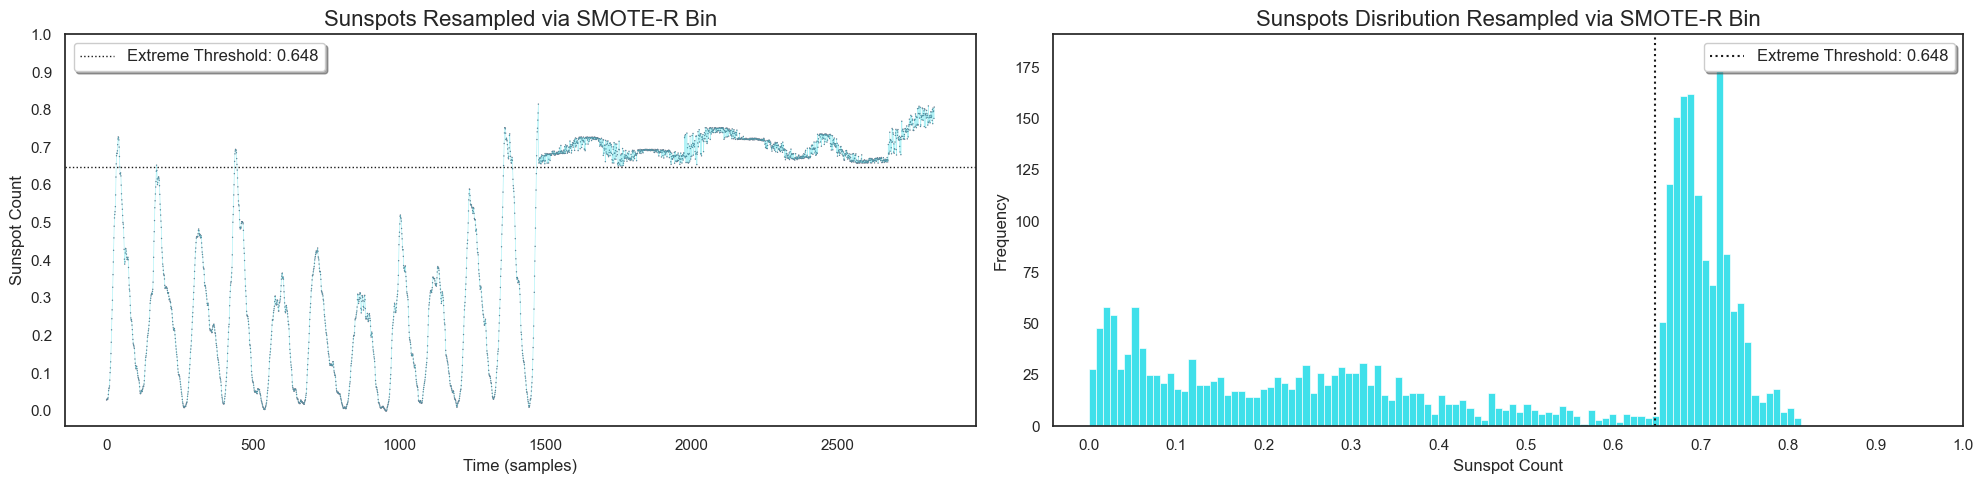

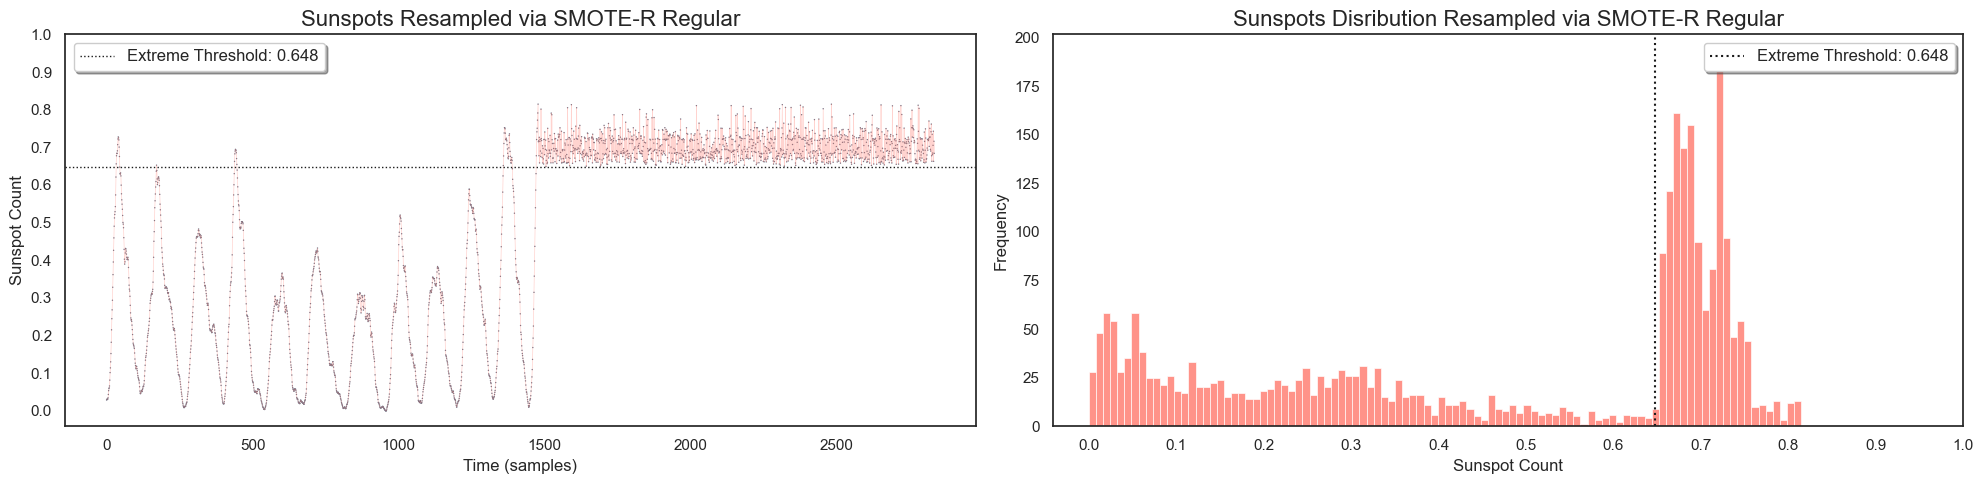

In [10]:
#import plt_utils as pu
#importlib.reload(pu)
#only plots first step out in each embedded
pu.PlotResampledResults(resampling_results, k_X.shape[0], N_STEPS_OUT,EXTREMES_THRESHOLD, TVAR, DATA_NAME)

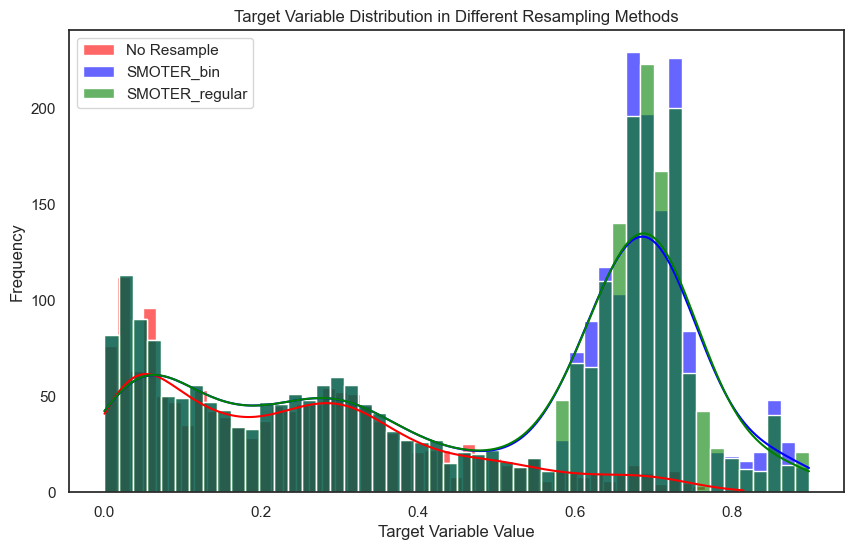

In [11]:
# 未采样的目标变量
no_resample_targets = Y_train[:, 0]  

# SMOTER 生成的目标变量
smoter_bin_targets = resampling_results['SMOTER_bin'][:, -1]  
smoter_regular_targets = resampling_results['SMOTER_regular'][:, -1]  

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

# 绘制目标变量的直方图 + KDE 曲线
sns.histplot(no_resample_targets, bins=50, kde=True, label="No Resample", color='red', alpha=0.6)
sns.histplot(smoter_bin_targets, bins=50, kde=True, label="SMOTER_bin", color='blue', alpha=0.6)
sns.histplot(smoter_regular_targets, bins=50, kde=True, label="SMOTER_regular", color='green', alpha=0.6)

plt.xlabel("Target Variable Value")
plt.ylabel("Frequency")
plt.title("Target Variable Distribution in Different Resampling Methods")
plt.legend()
plt.show()

### Remove Bad GANs

Save time training the forecasters by removing GANs that will clearly generate bad results

In [12]:
all_resampling_results = resampling_results.copy() #save a copy just incase
to_delete = ['GAN_CNN_e0', 'GAN_CNN_e10', 'GAN_CNN_e20', 'GAN_CNN_e110', 'GAN_CNN_e80', 'GAN_CNN_e50', 'GAN_CNN_e60', 'GAN_CNN_e70', 'GAN_CNN_e90', 'GAN_CNN_e100', 'GAN_FNN_e0', 'GAN_FNN_e10', 'GAN_FNN_e20', 'GAN_FNN_e30', 'GAN_FNN_e40', 'GAN_FNN_e50', 'GAN_FNN_e60', 'GAN_FNN_e70', 'GAN_FNN_e80', 'GAN_FNN_e90'] #['GAN_CNN_e10'] #specify resampling results to delete from the dictionary
print(resampling_results.keys())
for d in to_delete:
    del resampling_results[d]
print(resampling_results.keys())

dict_keys(['SMOTER_bin', 'SMOTER_regular'])


KeyError: 'GAN_CNN_e0'

# **Running Forecasting Experiments**

**Init Evaluator object for model eval metrics**

In [13]:
import evaluator as ev
importlib.reload(ev)

#NOTE: evaler_params must include CaseWeight else errors in MODEL_LSTM
evaluator_params = { "RMSE": {},
                     "RMSERare": {},
                     "SER": {},
                     "Utility": {'m':0.5},
                     "CaseWeight": {'m':0.5},
                     "PrecisionRecall": {},
                     "FScore": {'beta':0.5},
                     #"RelevanceROC": {},
                   }
EVALERS = {}
for f in FORECASTERS:
    EVALERS[f] = ev.Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)

#EVALER = ev.Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)
RECORDER.save_param_dict({"Evaluator":evaluator_params})

**Train and evaluate an LSTM for each resampling strategy**

In [24]:
NUM_EXPERIMENTS = 10

def main(time_step, X_train, X_test, Y_train, Y_test, resampling_results, evalers, recorder, train_params):   
    recorder.log_print(f"Starting forecasting experiments with num_exps: {train_params['num_exp']} and epochs: {train_params['epochs']}")
    recorder.save_param_dict({"Forecasting":{"NumExp":train_params['num_exp'], "nEpochs": train_params['epochs'], "hidden":train_params['hidden']}})
    
    forecast_results = {}
    for f in FORECASTERS:
        print(f"############## no_resample : {f} ##############")
        if f == "Conv_LSTM":
            best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_CONV_LSTM(X_train, X_test, Y_train, Y_test, "no_resample", train_params, evalers[f], recorder.log_print)
        else:
            best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_BD_LSTM(X_train, X_test, Y_train, Y_test, "no_resample", train_params, evalers[f], recorder.log_print)
    
        results = {'predict_test':best_predict_test,'predict_train':best_predict_train,'X_train':X_train,'Y_train':Y_train,'model':best_model}
        forecast_results[f] = {}
        forecast_results[f]['no_resample'] = results
    
    
    for key in resampling_results.keys():
        res = resampling_results[key]
        X_res = res[:,:(N_STEPS_IN*N_FVARS)]
        X_res = X_res.reshape((X_res.shape[0],N_STEPS_IN,N_FVARS))
        Y_res = res[:,(N_STEPS_IN*N_FVARS):]
        for f in FORECASTERS:
            print(f"############## {key} : {f} ##############")
            if f == "Conv_LSTM":
                best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_CONV_LSTM(X_res, X_test, Y_res, Y_test, key, train_params, evalers[f], recorder.log_print)
            else:
                best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_BD_LSTM(X_res, X_test, Y_res, Y_test, key, train_params, evalers[f], recorder.log_print)
        
            results = {'predict_test':best_predict_test,'predict_train':best_predict_train,'X_train':X_res,'Y_train':Y_res,'model':best_model}
            forecast_results[f][key] = results
    
    return forecast_results

TRAIN_PARAMS = {
        'num_exp': NUM_EXPERIMENTS, 
        'n_steps_in': N_STEPS_IN,
        'n_steps_out': N_STEPS_OUT,
        'epochs': 50,
        'hidden': 100,
        'forecast_dir': FORECAST_DIR,
        'n_fvars': N_FVARS
    }

forecast_results = main(N_STEPS_IN, X_train, X_test, Y_train, Y_test, resampling_results, EVALERS, RECORDER, TRAIN_PARAMS)

print("$$$$ FINISHED FORECASTING EXPERIMENTS $$$$")

LOG: 08:08:54:717 Starting forecasting experiments with num_exps: 10 and epochs: 50

############## no_resample : Conv_LSTM ##############
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 5, 1, 1, 64)       16896     
                                                                 
 flatten_17 (Flatten)        (None, 320)               0         
                                                                 
 dense_34 (Dense)            (None, 5)                 1605      
                                                                 
Total params: 18,501
Trainable params: 18,501
Non-trainable params: 0
_________________________________________________________________
LOG: 08:08:54:830 Starting Conv-LSTM forecaster training on no_resample

LOG: 08:08:54:831 	Experiment 1 in progress
20/20 [==============================] - 0s 662us/step
LO

## *SAVE EVALER RESULTS ---- DON'T FORGET*

In [25]:
for f in FORECASTERS:
    RECORDER.save_all_evaler_exps(EVALERS[f].getResultsDf(), f)

In [21]:
EVALERS[f].getResultsDf()

Exp             Res    Time(s)  \
0    1     no_resample   0.200098   
1    1      SMOTER_bin   0.231943   
2    1  SMOTER_regular   0.217643   
3    1     no_resample   0.460369   
4    2     no_resample   0.262412   
5    3     no_resample   0.267705   
6    4     no_resample   0.530660   
7    5     no_resample   0.480178   
8    6     no_resample   0.289676   
9    7     no_resample   0.261961   
10   8     no_resample   0.270836   
11   9     no_resample   0.271992   
12  10     no_resample   0.258434   
13   1      SMOTER_bin   1.496220   
14   2      SMOTER_bin   0.492957   
15   3      SMOTER_bin   0.437226   
16   4      SMOTER_bin   0.445897   
17   5      SMOTER_bin   0.437766   
18   6      SMOTER_bin   0.440866   
19   7      SMOTER_bin   0.439341   
20   8      SMOTER_bin   0.438686   
21   9      SMOTER_bin   0.464330   
22  10      SMOTER_bin   0.448422   
23   1     no_resample   1.906541   
24   1      SMOTER_bin   1.721752   
25   1  SMOTER_regular   1.573205   
26   1     no_resample   8.993700   
27   2     no_resample   8.081733   
28   3     no_resample   8.092883   
29   4     no_resample   8.110581   
30   5     no_resample   8.016984   
31   6     no_resample   8.044954   
32   7     no_resample   8.416040   
33   8     no_resample   8.089461   
34   9     no_resample   8.017349   
35  10     no_resample   8.182198   
36   1      SMOTER_bin  16.422135   
37   2      SMOTER_bin  15.570514   
38   3      SMOTER_bin  15.625156   
39   4      SMOTER_bin  15.525638   
40   5      SMOTER_bin  15.543221   
41   6      SMOTER_bin  15.560271   
42   7      SMOTER_bin  15.549519   
43   8      SMOTER_bin  15.644505   
44   9      SMOTER_bin  16.330808   
45  10      SMOTER_bin  15.537989   
46   1  SMOTER_regular  16.269598   
47   2  SMOTER_regular  15.263214   
48   3  SMOTER_regular  15.144075   
49   4  SMOTER_regular  15.823183   
50   5  SMOTER_regular  18.094481   
51   6  SMOTER_regular  18.243954   
52   7  SMOTER_regular  17.235826   
53   8  SMOTER_regular  16.580906   
54   9  SMOTER_regular  15.929485   
55  10  SMOTER_regular  15.685861   

                                           RMSE_Train  \
0   [0.13726146855180446, 0.22916341757545117, 0.1...   
1   [0.10597139002831549, 0.13616348254719055, 0.1...   
2   [0.14911645515228933, 0.20711230048545262, 0.1...   
3   [0.024856773824161713, 0.03366967562669826, 0....   
4   [0.025926385881165446, 0.028988688678500064, 0...   
5   [0.014394181125155385, 0.021554503790790103, 0...   
6   [0.01514233987356443, 0.023540552425237248, 0....   
7   [0.016294613479677172, 0.023762993738862526, 0...   
8   [0.01621037550998933, 0.02339913880523972, 0.0...   
9   [0.01601605090081753, 0.02330872112627627, 0.0...   
10  [0.0152209154060812, 0.02277678107551414, 0.02...   
11  [0.014865943766972905, 0.022460001803342317, 0...   
12  [0.014169600058513959, 0.021952976345349106, 0...   
13  [0.03515736372178936, 0.04311049062245283, 0.0...   
14  [0.04583406624633853, 0.035324511594100785, 0....   
15  [0.04354033609363277, 0.04315692217433669, 0.0...   
16  [0.042014014981621876, 0.04454575697081956, 0....   
17  [0.0409047615126638, 0.045064892149271625, 0.0...   
18  [0.04178370143913819, 0.044787254612818586, 0....   
19  [0.04352772967687608, 0.0433569195670459, 0.04...   
20  [0.040592322452423744, 0.04144645627625285, 0....   
21  [0.040352970662478664, 0.04131954066171376, 0....   
22  [0.039073664364034186, 0.03943407145827504, 0....   
23  [0.1506770415858421, 0.13869103349462455, 0.13...   
24  [0.10491399418423916, 0.11432199425079831, 0.1...   
25  [0.09935998973396036, 0.10457187156123617, 0.1...   
26  [0.02987320858061949, 0.04073151938052539, 0.0...   
27  [0.026767110171577905, 0.03685379509106385, 0....   
28  [0.02497757476561685, 0.034522496324747624, 0....   
29  [0.02420158756548548, 0.03257992240606907, 0.0...   
30  [0.023041254068017162, 0.030385890178536292, 0...   
31  [0.012495824847990713, 0.02100224484072086, 0....   
32  [0.01201

In [26]:
df = EVALERS["Conv_LSTM"].getResultsDf()

# 只选 SER 和 RMSE_Test 相关列
cols = df.filter(like="SER").columns.tolist() + df.filter(like="RMSE_Test").columns.tolist()
ser_rmse_df = df[["Res"] + cols]  # ⬅️ 加上 Res 列

# 展开 SER 中的 array，取均值
ser_rmse_df[cols] = ser_rmse_df[cols].applymap(lambda x: np.mean(x) if isinstance(x, np.ndarray) else x)

# 按 Res 分组，计算均值和标准差
grouped = ser_rmse_df.groupby("Res")
mean_df = grouped.mean()
std_df = grouped.std()

# 拼成 "均值 ± 标准差" 格式
summary = mean_df.round(4).astype(str) + " ± " + std_df.round(4).astype(str)
summary

RMSERare_Train  SER_Train    RMSERare_Test   SER_Test  \
Res                                                                      
SMOTER_bin      0.0457 ± 0.0134  nan ± nan  0.0495 ± 0.0165  nan ± nan   
SMOTER_regular  0.0376 ± 0.0169  nan ± nan  0.0564 ± 0.0206  nan ± nan   
no_resample      0.085 ± 0.1229  nan ± nan   0.093 ± 0.1383  nan ± nan   

                    SER1%_Train      SER2%_Train      SER5%_Train  \
Res                                                                 
SMOTER_bin      0.0545 ± 0.0156  0.0545 ± 0.0156  0.0545 ± 0.0156   
SMOTER_regular  0.0515 ± 0.0256  0.0515 ± 0.0253  0.0501 ± 0.0233   
no_resample     0.0815 ± 0.0857  0.0775 ± 0.0802   0.0719 ± 0.079   

                   SER10%_Train     SER25%_Train     SER50%_Train  \
Res                                                                 
SMOTER_bin      0.0545 ± 0.0155  0.0539 ± 0.0144    0.05 ± 0.0138   
SMOTER_regular   0.048 ± 0.0221  0.0424 ± 0.0234  0.0418 ± 0.0208   
no_resample     0.0697 ± 0.0753  0.0634 ± 0.0697  0.0562 ± 0.0574   

                   SER75%_Train       SER1%_Test       SER2%_Test  \
Res                                                                 
SMOTER_bin      0.0513 ± 0.0201  0.0551 ± 0.0206  0.0551 ± 0.0206   
SMOTER_regular   0.0496 ± 0.027   0.074 ± 0.0331   0.074 ± 0.0331   
no_resample     0.0497 ± 0.0455  0.0986 ± 0.1275  0.0958 ± 0.1167   

                     SER5%_Test      SER10%_Test      SER25%_Test  \
Res                                                                 
SMOTER_bin      0.0551 ± 0.0206  0.0551 ± 0.0206  0.0588 ± 0.0216   
SMOTER_regular   0.074 ± 0.0331   0.071 ± 0.0301  0.0662 ± 0.0284   
no_resample      0.094 ± 0.1124  0.0934 ± 0.1096  0.0861 ± 0.1047   

                    SER50%_Test      SER75%_Test        RMSE_Test  
Res                                                                
SMOTER_bin      0.0582 ± 0.0248  0.0562 ± 0.0302  0.0529 ± 0.0335  
SMOTER_regular  0.0678 ± 0.0329  0.0663 ± 0.0372  0.0618 ± 0.0394  
no_resample     0.0757 ± 0.0891  0.0681 ± 0.0762  0.0597 ± 0.0706

In [27]:
df2 = EVALERS["BD_LSTM"].getResultsDf()

# 只选 SER 和 RMSE_Test 相关列
cols = df2.filter(like="SER").columns.tolist() + df2.filter(like="RMSE_Test").columns.tolist()
ser_rmse_df = df2[["Res"] + cols]  # ⬅️ 加上 Res 列

# 展开 SER 中的 array，取均值
ser_rmse_df[cols] = ser_rmse_df[cols].applymap(lambda x: np.mean(x) if isinstance(x, np.ndarray) else x)

# 按 Res 分组，计算均值和标准差
grouped = ser_rmse_df.groupby("Res")
mean_df = grouped.mean()
std_df = grouped.std()

# 拼成 "均值 ± 标准差" 格式
summary2 = mean_df.round(4).astype(str) + " ± " + std_df.round(4).astype(str)
summary2

RMSERare_Train  SER_Train    RMSERare_Test   SER_Test  \
Res                                                                      
SMOTER_bin      0.0429 ± 0.0214  nan ± nan  0.0543 ± 0.0257  nan ± nan   
SMOTER_regular  0.0351 ± 0.0246  nan ± nan  0.0838 ± 0.0727  nan ± nan   
no_resample     0.0654 ± 0.0847  nan ± nan  0.1238 ± 0.1131  nan ± nan   

                    SER1%_Train      SER2%_Train      SER5%_Train  \
Res                                                                 
SMOTER_bin       0.047 ± 0.0124   0.047 ± 0.0124   0.047 ± 0.0124   
SMOTER_regular  0.0487 ± 0.0299  0.0472 ± 0.0273   0.044 ± 0.0224   
no_resample     0.0687 ± 0.0522  0.0651 ± 0.0474  0.0604 ± 0.0449   

                   SER10%_Train     SER25%_Train     SER50%_Train  \
Res                                                                 
SMOTER_bin      0.0468 ± 0.0122  0.0456 ± 0.0132   0.046 ± 0.0187   
SMOTER_regular  0.0411 ± 0.0196  0.0343 ± 0.0149  0.0374 ± 0.0197   
no_resample       0.0577 ± 0.04  0.0533 ± 0.0429   0.0484 ± 0.038   

                   SER75%_Train       SER1%_Test       SER2%_Test  \
Res                                                                 
SMOTER_bin      0.0489 ± 0.0223   0.0611 ± 0.024   0.0611 ± 0.024   
SMOTER_regular  0.0465 ± 0.0269  0.1103 ± 0.0971  0.1103 ± 0.0971   
no_resample     0.0449 ± 0.0353  0.1481 ± 0.1253  0.1467 ± 0.1217   

                     SER5%_Test      SER10%_Test      SER25%_Test  \
Res                                                                 
SMOTER_bin       0.0611 ± 0.024  0.0601 ± 0.0221  0.0591 ± 0.0203   
SMOTER_regular  0.1103 ± 0.0971  0.1048 ± 0.0962   0.0829 ± 0.061   
no_resample     0.1457 ± 0.1191  0.1449 ± 0.1177   0.114 ± 0.0842   

                    SER50%_Test      SER75%_Test        RMSE_Test  
Res                                                                
SMOTER_bin      0.0582 ± 0.0224  0.0561 ± 0.0249   0.0525 ± 0.027  
SMOTER_regular  0.0776 ± 0.0437  0.0721 ± 0.0389   0.065 ± 0.0365  
no_resample       0.092 ± 0.065  0.0804 ± 0.0548  0.0691 ± 0.0526

### Plot Actual vs Predicted

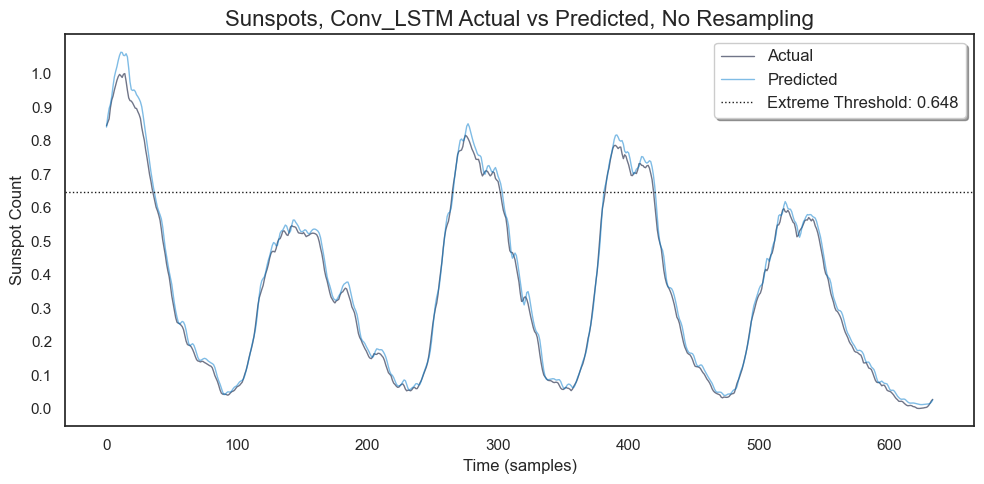

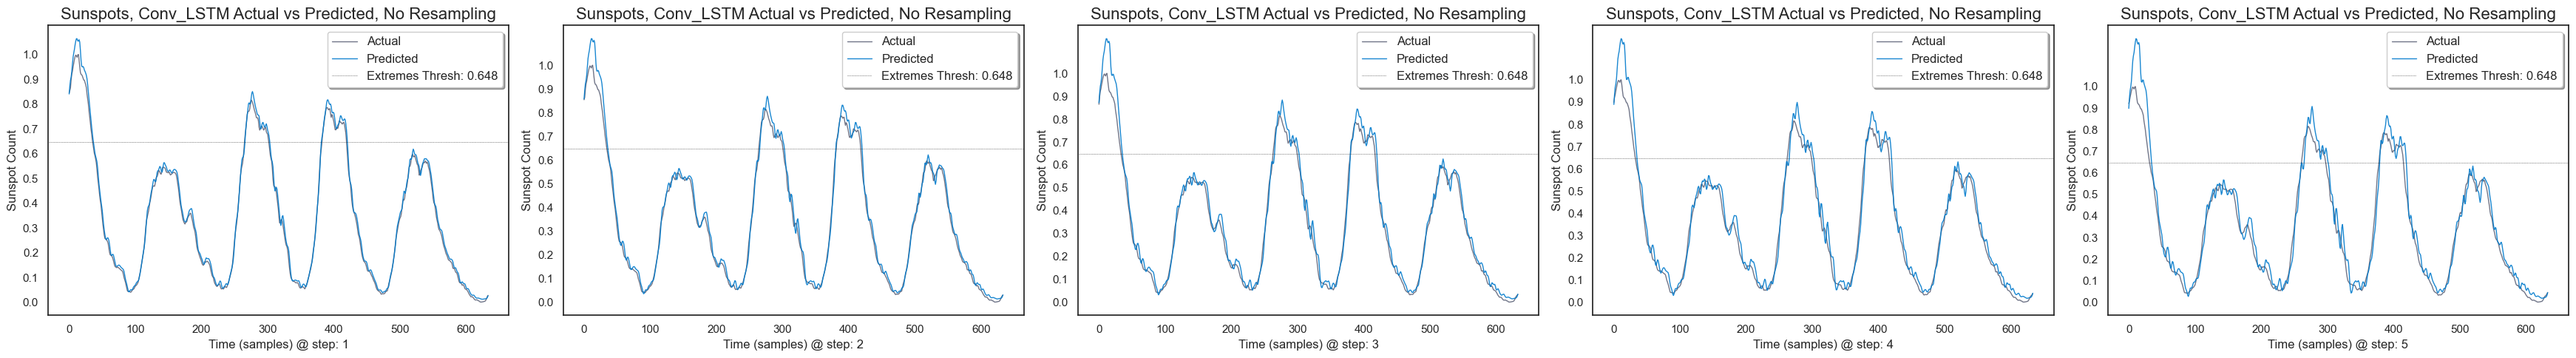

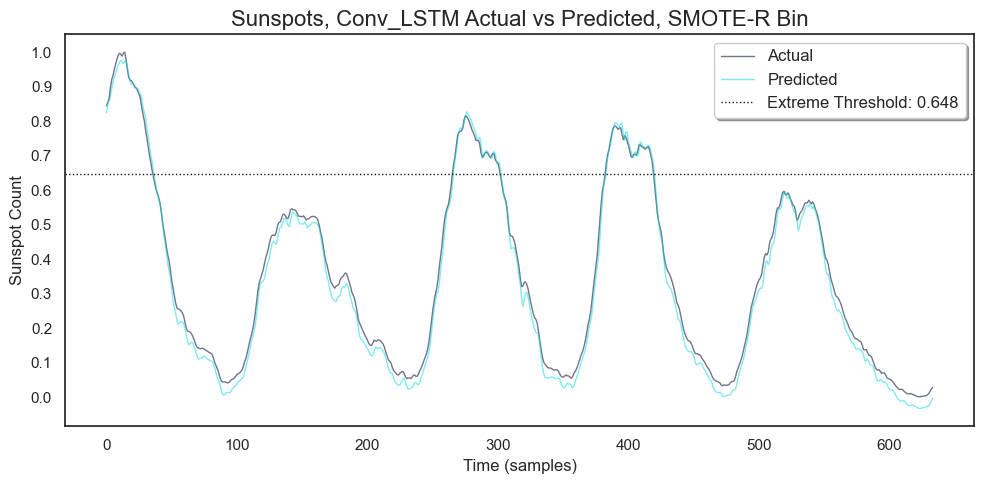

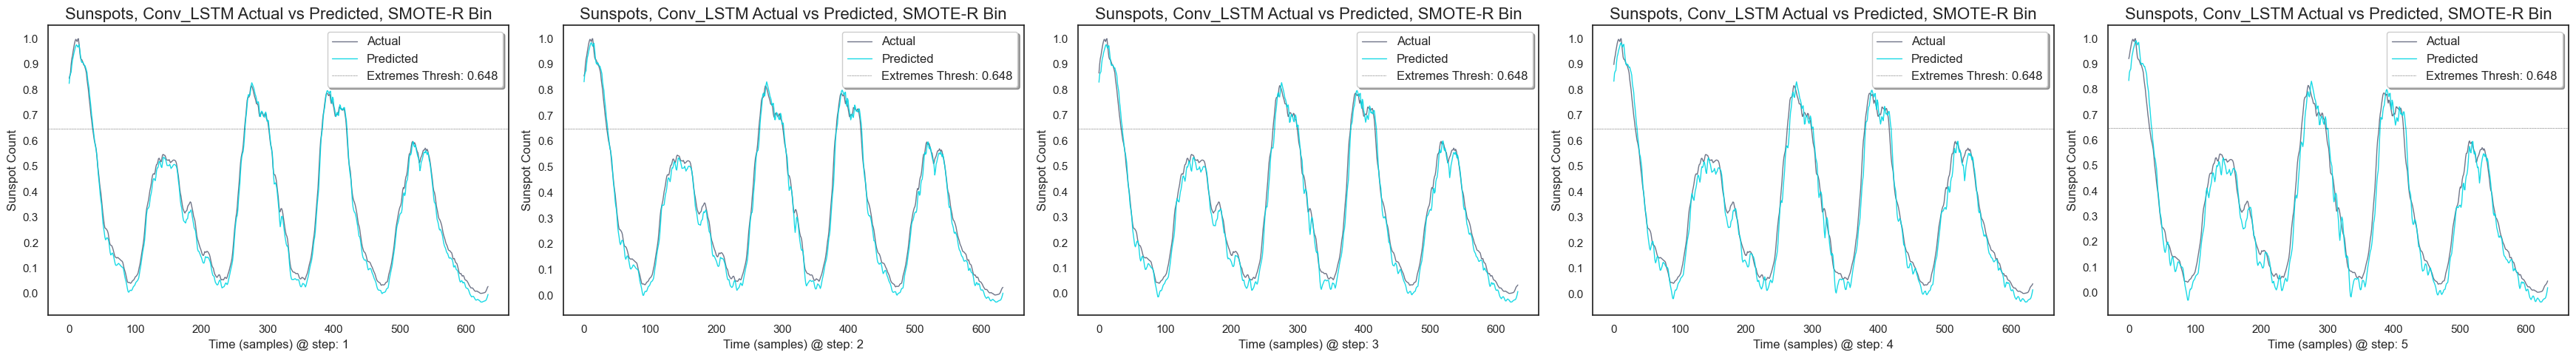

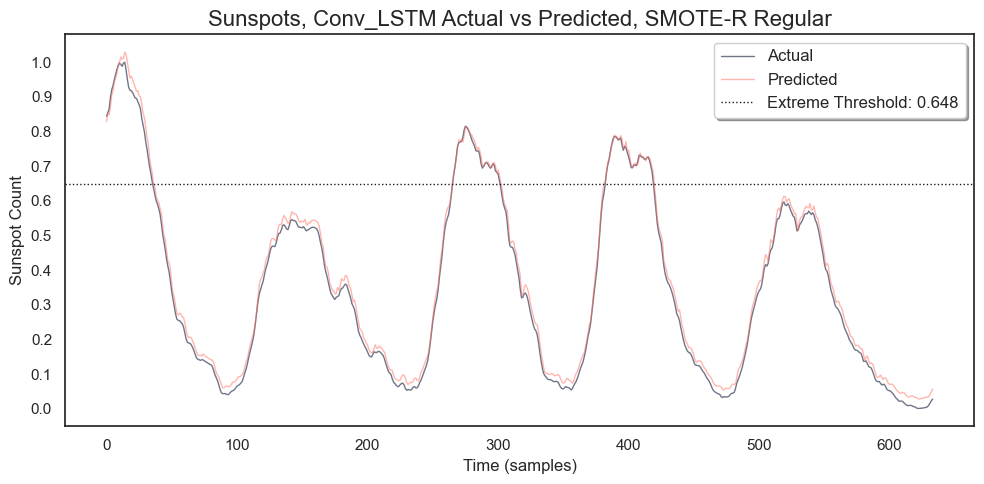

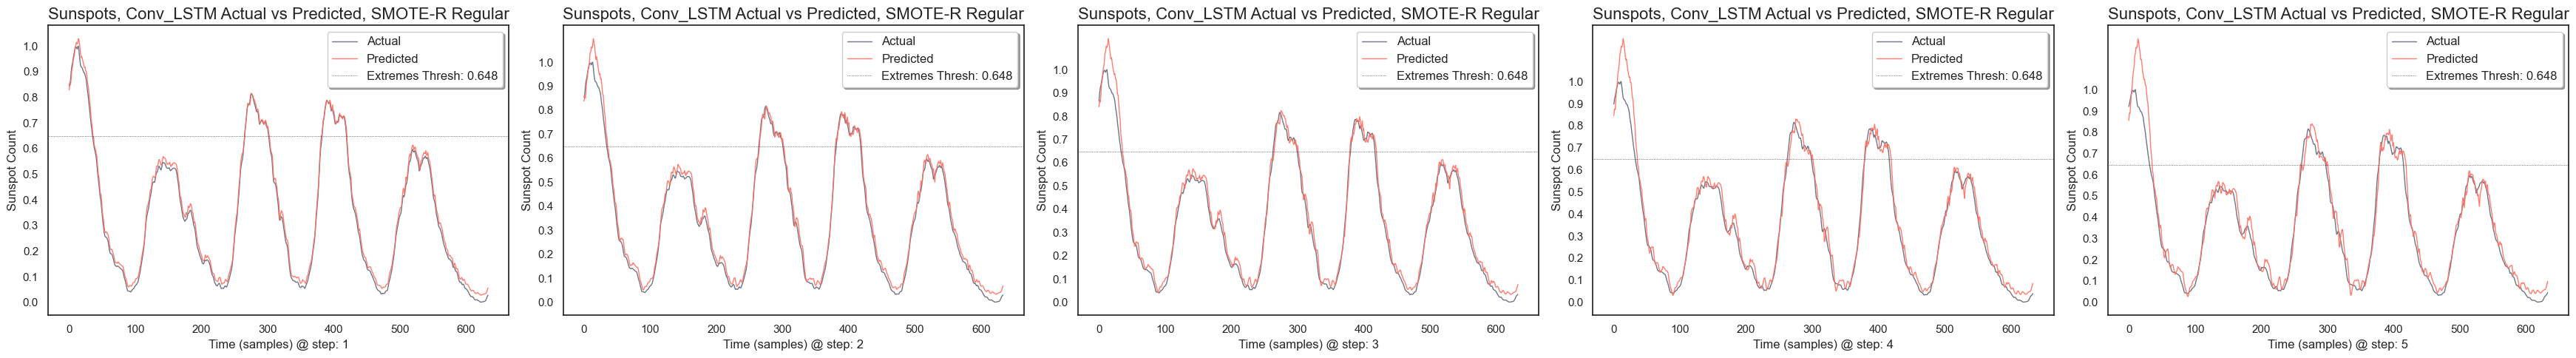

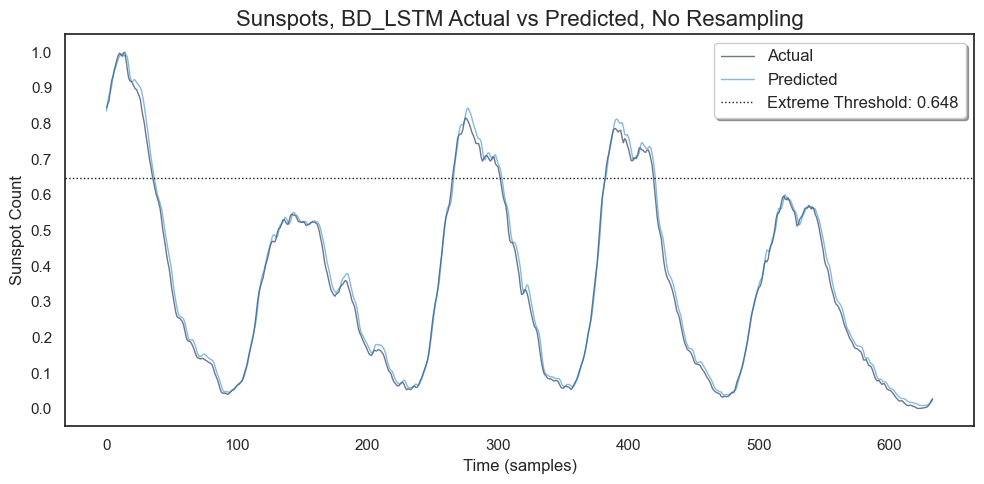

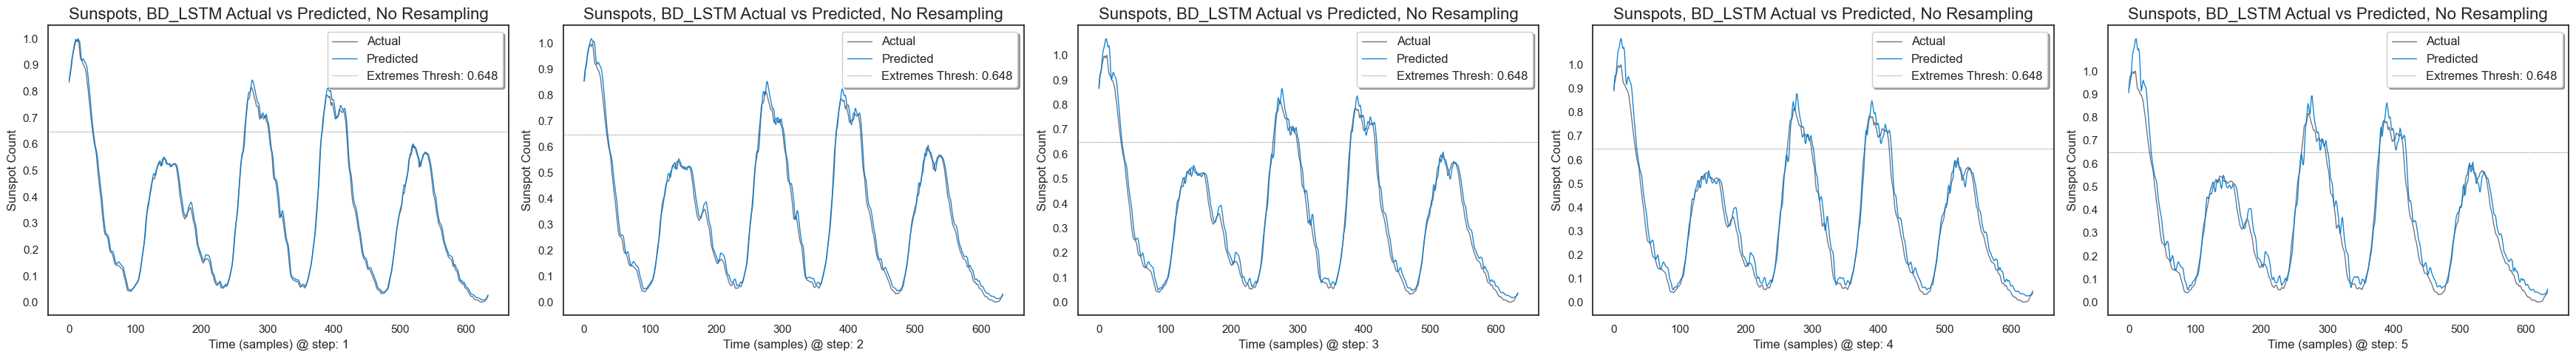

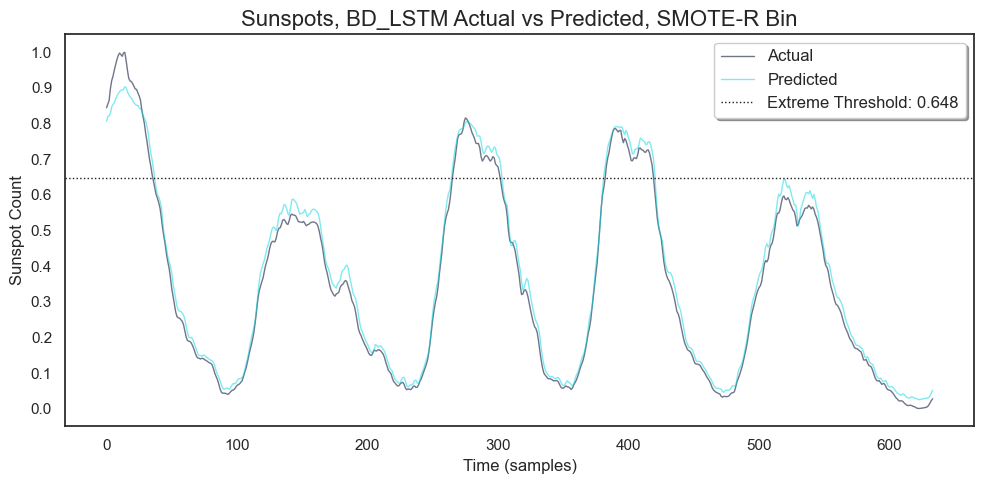

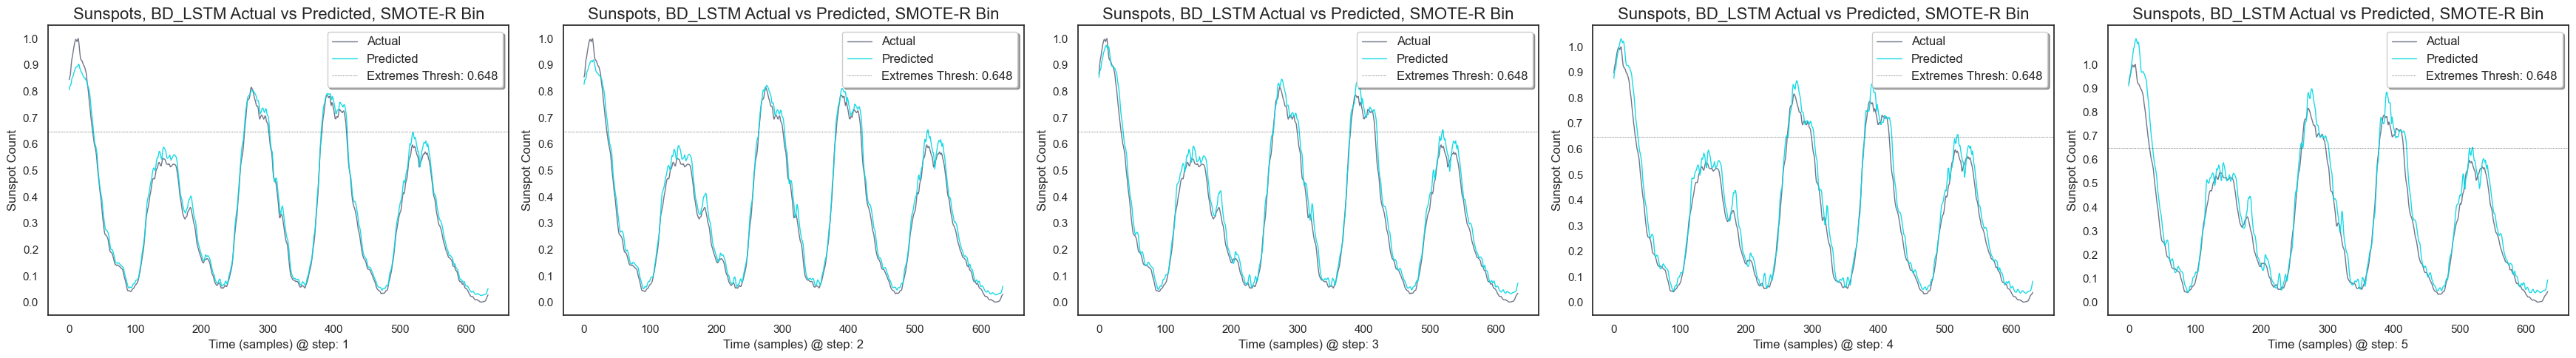

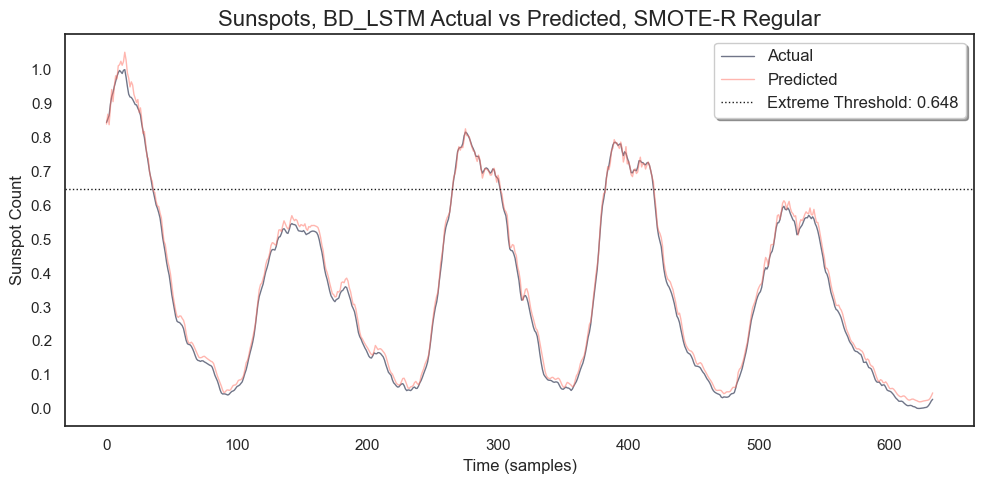

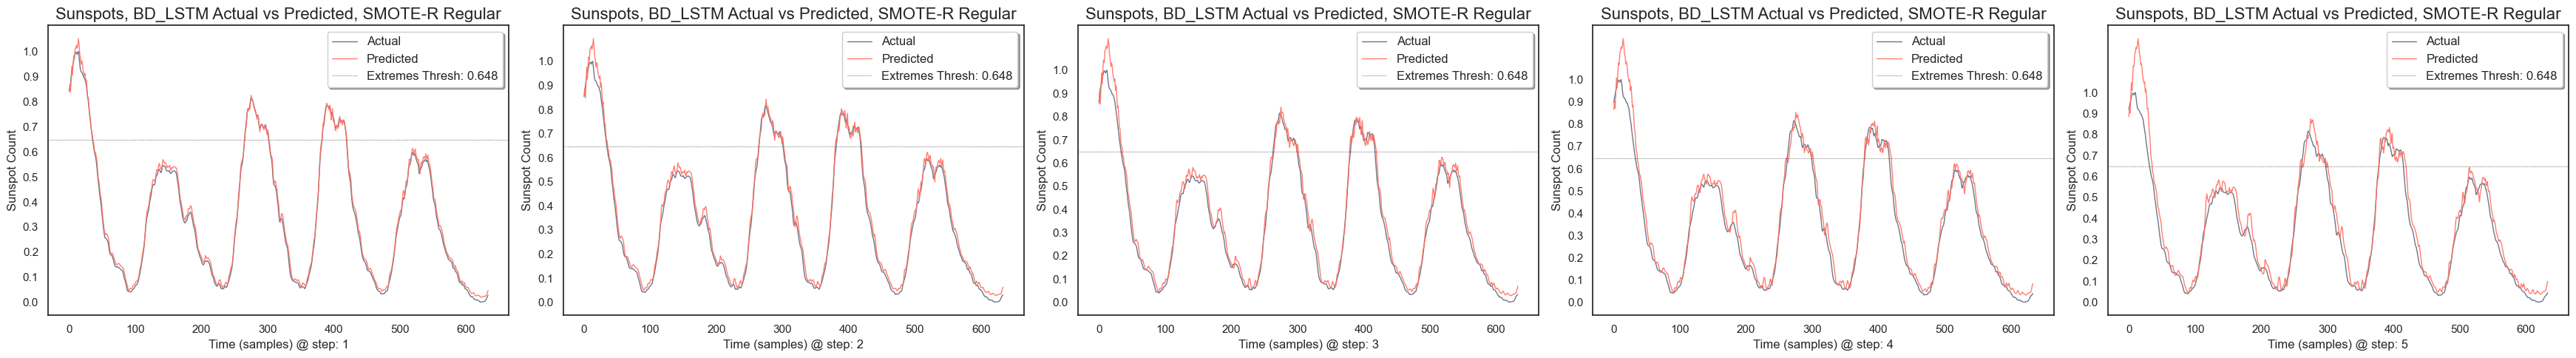

In [28]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)
#print(forecast_results)
#PLOT PRED VS ACTUAL + SAVE_EVAL_RESULTS
for f in FORECASTERS:
    for key in forecast_results[f].keys():
        y_predict_test = forecast_results[f][key]['predict_test']
        #Plot a single Actual vs Predicted figure for only one chosen step out: 0 for first step
        pu.PlotPredVsActual1D(Y_test, y_predict_test, key, EXTREMES_THRESHOLD, TVAR, DATA_NAME, f, 0)
        #Plot a Actual vs Predicted for all steps out in one figure
        pu.PlotPredVsActualSteps(Y_test, y_predict_test, key, EXTREMES_THRESHOLD, TVAR, DATA_NAME, N_STEPS_OUT, f)
        #Save forecasting model
        RECORDER.save_LSTM(forecast_results[f][key]['model'], key)
        #TODO: save CNN and LSTM with same function

### Record KS Statistic and Plot Extremes Distribution for Each Resampling Strategy

KS statistic: 0.08701847882755025, p-value: 0.7332583215532449


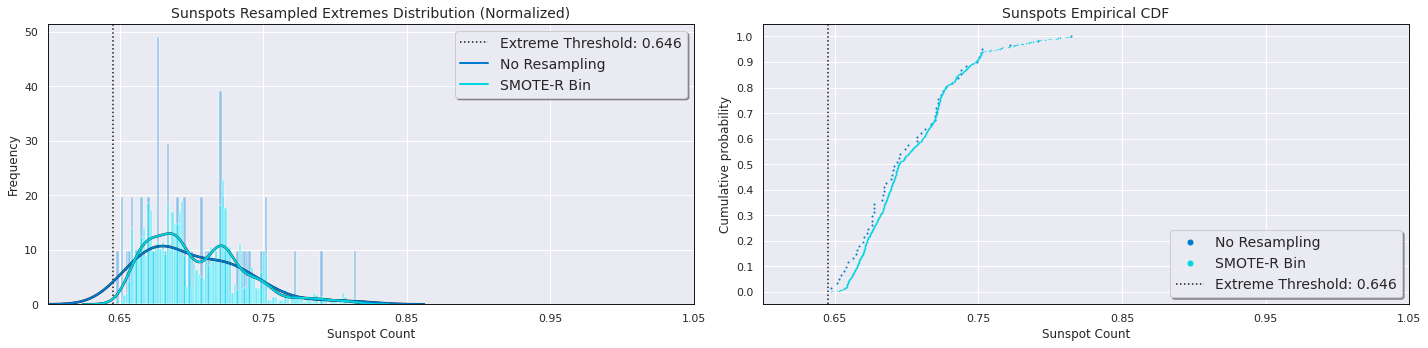

KS statistic: 0.0983258993222499, p-value: 0.5878761158327238


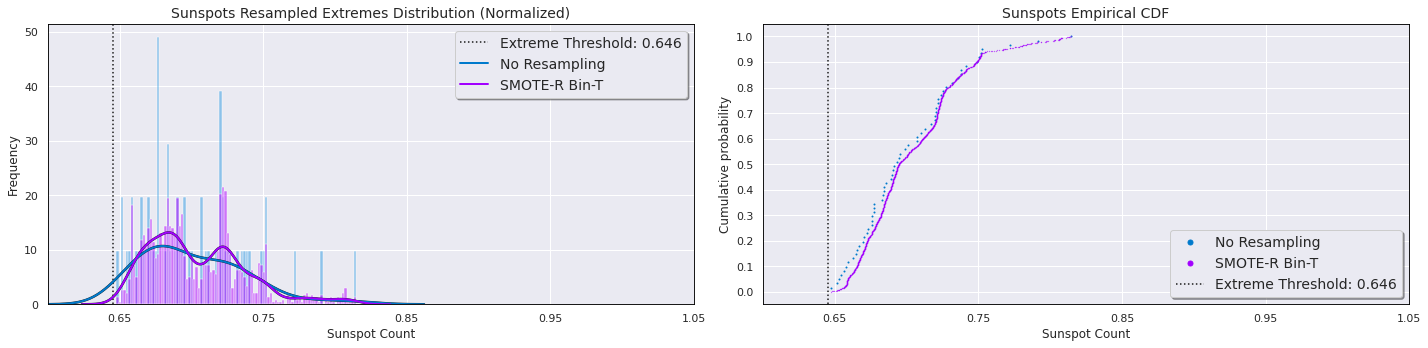

KS statistic: 0.13507501593002375, p-value: 0.21511207260824672


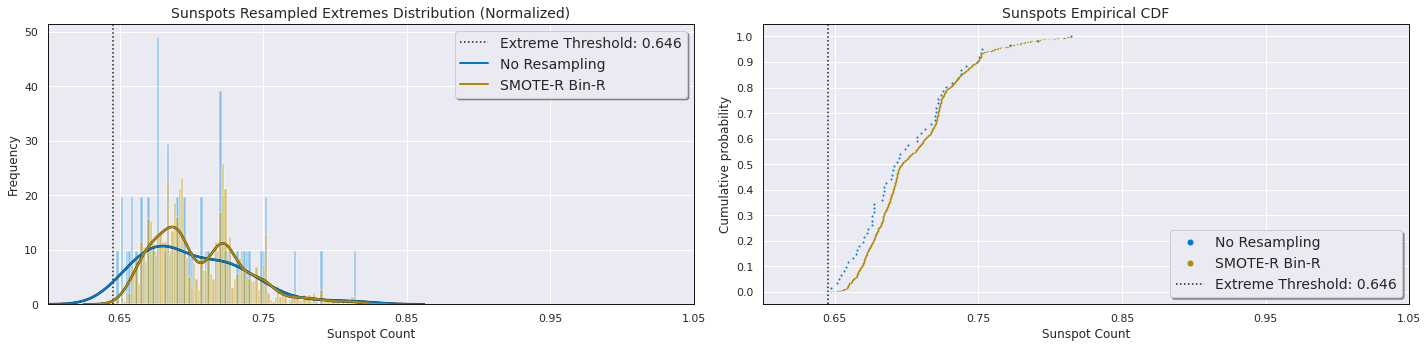

KS statistic: 0.1287145919017552, p-value: 0.26287202871219506


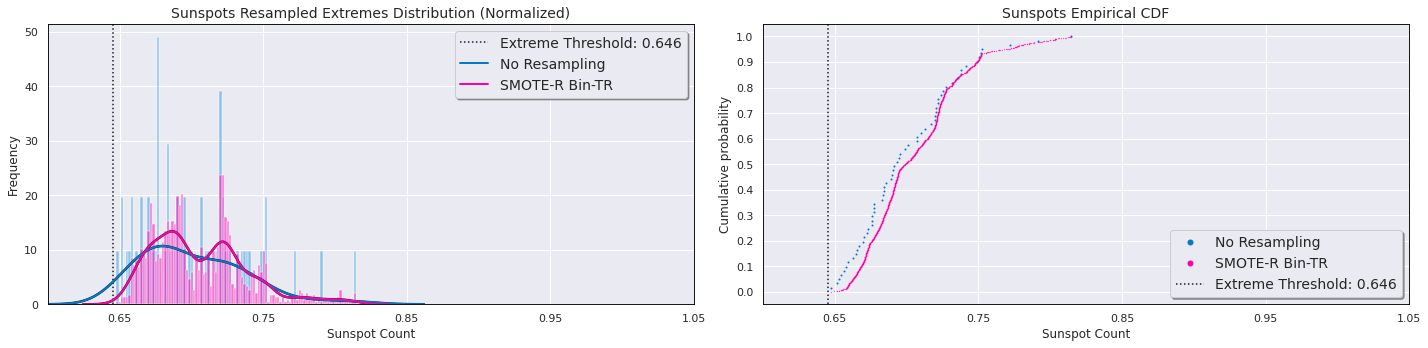

KS statistic: 0.9568904593639576, p-value: 6.6338232155416566e-74


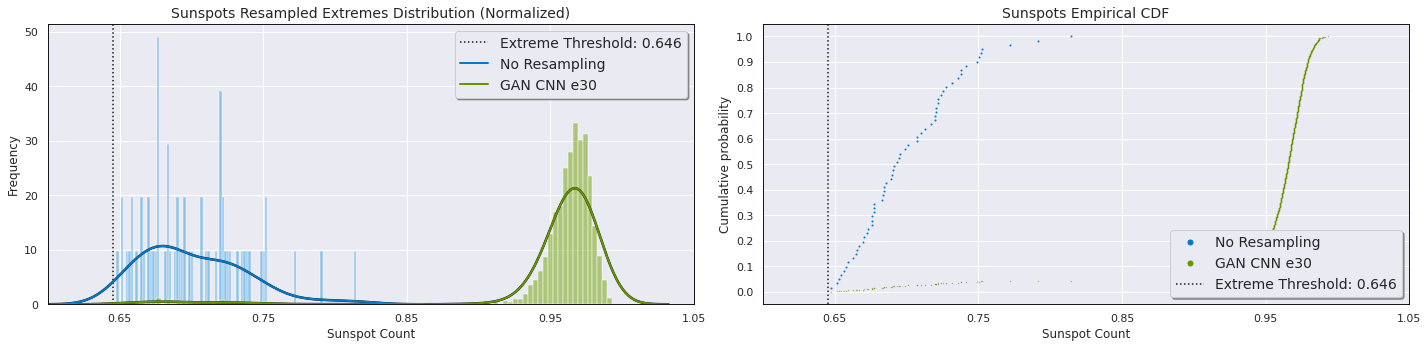

KS statistic: 0.2843034903078356, p-value: 0.00012228161898364937


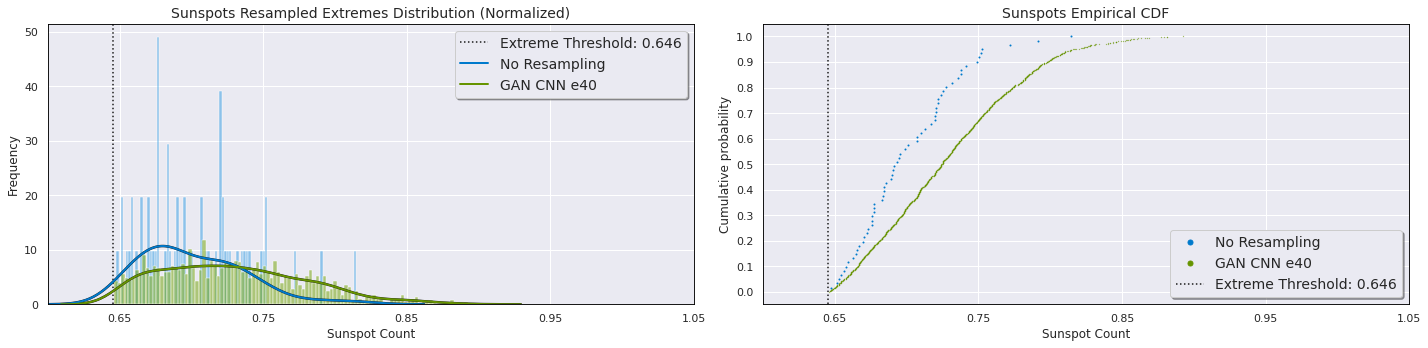

KS statistic: 0.0835978605905118, p-value: 0.7918571533513971


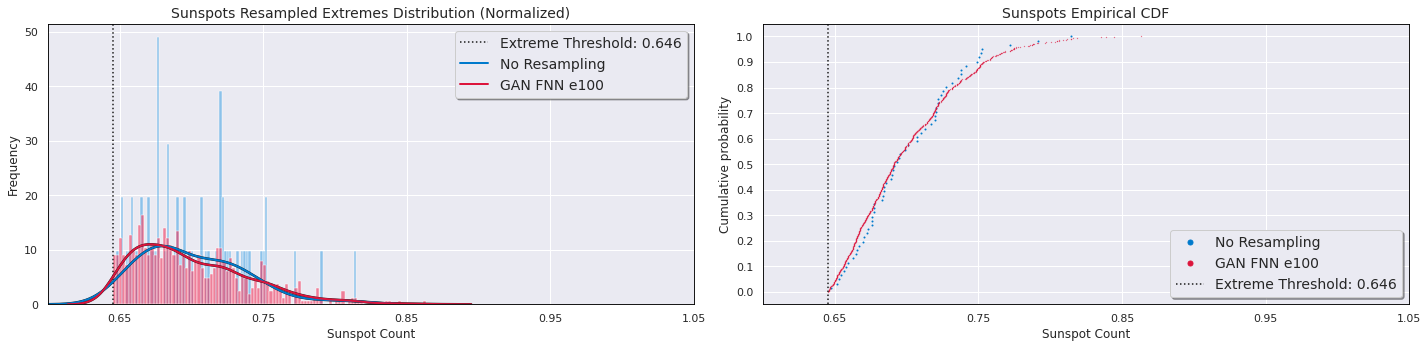

KS statistic: 0.09344734728586951, p-value: 0.6738629009046565


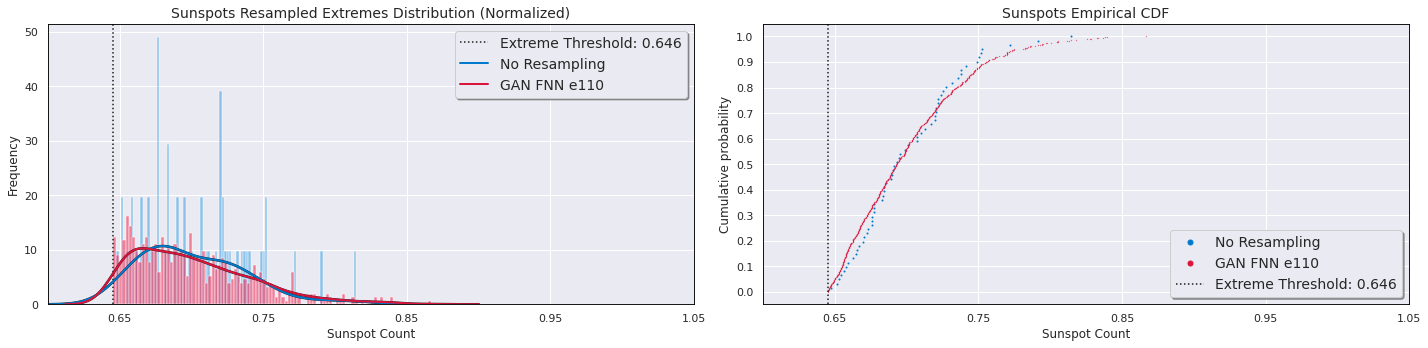

KS statistic: 0.05985862535719657, p-value: 0.9762244842385925


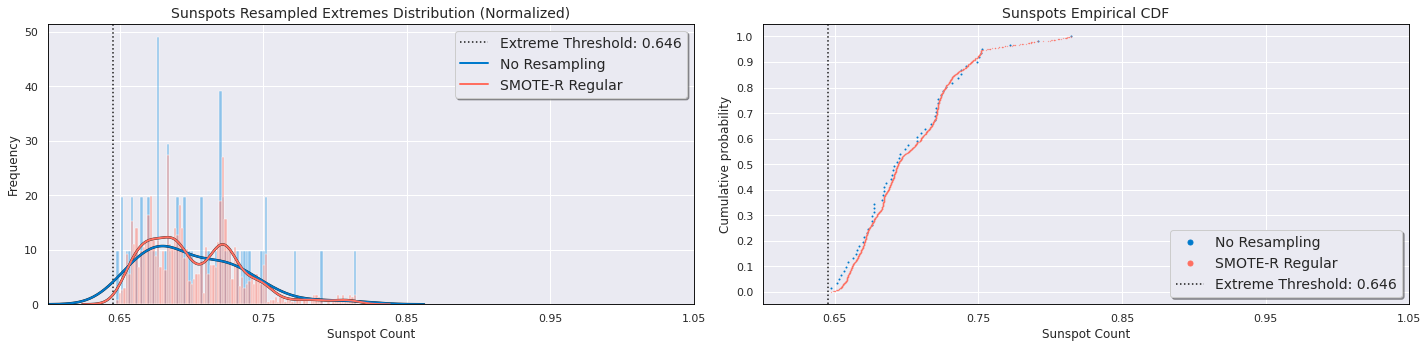

In [17]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)
from scipy.stats import ks_2samp
import scipy.stats as stats

step_out = 0
#get extremes for original data
y_orig_rel = RELEVANCE_FUNCTION.__call__(Y_train[:,step_out])
rare_mask = [val >= RELEVANCE_THRESHOLD for val in y_orig_rel]
y_orig_rare = Y_train[rare_mask]
ks_results = []
for key, res in resampling_results.items():
    #get extremes for resampled data
    y_res = res[:,(N_STEPS_IN*N_FVARS):]
    y_rel = RELEVANCE_FUNCTION.__call__(y_res[:,step_out])
    rare_mask = [val >= RELEVANCE_THRESHOLD for val in y_rel]
    y_rare = y_res[rare_mask]

    # Perform the Kolmogorov-Smirnov test
    statistic, p_value = ks_2samp(y_orig_rare[:,step_out], y_rare[:,step_out])
    print(f"KS statistic: {statistic}, p-value: {p_value}")
    ks_results.append({'Res':key, 'ksStat':statistic, 'pValue':p_value})
    #Plot extremes hist and cdf for each strategy vs original data
    pu.PlotExremesDistribution(y_orig_rare, y_rare, key, step_out, EXTREMES_THRESHOLD, TVAR, DATA_NAME)
    

ks_df = pd.DataFrame(ks_results)
RECORDER.save_ks(ks_df)

### Prepare Data for Comparison Plots

If we include all strategies on the comparison plots they will be really cluttered and almost useless to the reader. In the following cell we choose the best CNN_GAN, FNN_GAN, and SMOTER_bin approach from the RMSERare of the forecasting results and only include these on the comparison plots. 

Later we'll also use this cell to load the base resampling results / eval metrics to include on the comparison plots along side the next generation of resampling strategies

In [18]:
def calculate_mean(lst):
    return sum(lst) / len(lst)

#Combine EVALER from loaded experiments
#Combine resampling results from loaded experiments
#np.loadtxt('test.txt', delimiter=',', dtype=float)

#TODO: come up with a way to make a copy of evaler so we don't have to filter best strategies for the clustered bar plots

#best_resampling_results will contain best GANs, best SMOTERs
best_resampling_results = resampling_results.copy()
best_cnn_gan = ""
best_fnn_gan = ""
best_bin = ""

def get_best_resampling(forecaster, best, evaler, metric, recorder):
    exp_sum = evaler.getExperimentSummaryDf(metric)
    #get best CNN_GAN if used
    cnn_exp_sum = exp_sum[exp_sum['Res'].str.contains("GAN_CNN")]
    if not cnn_exp_sum.empty:
        #apply mean to all rows
        cnn_exp_sum[f"{metric}_Test_Mean"] = cnn_exp_sum[f"{metric}_Test_Mean"].apply(calculate_mean)
        max_cw_idx = cnn_exp_sum[f"{metric}_Test_Mean"].idxmin()
        best_cnn_gan = cnn_exp_sum.at[max_cw_idx, "Res"]
        print(f"Best CNN_GAN for {forecaster}: {best_cnn_gan}")
        keys_to_delete = [key for key in best['resampling_results'].keys() if "GAN_CNN" in key and key != best_cnn_gan]
        print(f"deleting keys: {keys_to_delete}")
        for key in keys_to_delete:
            del best['resampling_results'][key]
        best['cnn_gan'] = best_cnn_gan
        ekey = int(best_cnn_gan.split('_')[-1][1:])
        recorder.save_gan(CNN_GENS[ekey], CNN_DISCS[ekey], "CNN", best_cnn_gan)
    
    #get best FNN_GAN if used
    fnn_exp_sum = exp_sum[exp_sum['Res'].str.contains("GAN_FNN")]
    if not fnn_exp_sum.empty:
        #apply mean to all rows
        fnn_exp_sum[f"{metric}_Test_Mean"] = fnn_exp_sum[f"{metric}_Test_Mean"].apply(calculate_mean)
        max_cw_idx = fnn_exp_sum[f"{metric}_Test_Mean"].idxmin()
        best_fnn_gan = fnn_exp_sum.at[max_cw_idx, "Res"]
        print(f"Best FNN_GAN for {forecaster}: {best_fnn_gan}")
        keys_to_delete = [key for key in best['resampling_results'].keys() if "GAN_FNN" in key and key != best_fnn_gan]
        print(f"deleting keys: {keys_to_delete}")
        for key in keys_to_delete:
            del best['resampling_results'][key]
        best['fnn_gan'] = best_fnn_gan
        ekey = int(best_fnn_gan.split('_')[-1][1:])
        RECORDER.save_gan(FNN_GENS[ekey], FNN_DISCS[ekey], "FNN", best_fnn_gan)
    #get best SMOTER_bin if used
    bin_exp_sum = exp_sum[exp_sum['Res'].str.contains("SMOTER_bin")] 
    if not bin_exp_sum.empty:
        bin_exp_sum[f"{metric}_Test_Mean"] = bin_exp_sum[f"{metric}_Test_Mean"].apply(calculate_mean)
        max_cw_idx = bin_exp_sum[f"{metric}_Test_Mean"].idxmin()
        best_bin = bin_exp_sum.at[max_cw_idx, "Res"]
        print(f"Best SMOTER bin for {forecaster}: {best_bin}")
        keys_to_delete = [key for key in best['resampling_results'].keys() if "SMOTER_bin" in key and key != best_bin]
        print(f"deleting keys: {keys_to_delete}")
        for key in keys_to_delete:
            del best['resampling_results'][key]
        best['bin'] = best_bin
    return best #?
                                                         

BEST_RESULTS = {}
for f in FORECASTERS:
    BEST_RESULTS[f] = {'resampling_results': resampling_results.copy(), 'cnn_gan': "", 'fnn_gan': "", "bin": ""}
    #do below stuff with argument 'f'
    BEST_RESULTS[f] = get_best_resampling(f, BEST_RESULTS[f], EVALERS[f], 'RMSERare', RECORDER) #?
    RECORDER.save_resample_results_np(BEST_RESULTS[f]['resampling_results'], f)


#load all resampling results
#COMBINE_RESAMPLING_RESULTS_DIR = Path("Sessions/Bike/2023-October-13 13-41-03-532984").joinpath("resample_results")

#add loaded resampling results to best_resampling_results
#best_resampling_results.update({file.stem: np.loadtxt(file, delimiter=',', dtype=float)
#                  for file in COMBINE_RESAMPLING_RESULTS_DIR.iterdir() if file.is_file()})

Best CNN_GAN for LSTM: GAN_CNN_e30
deleting keys: ['GAN_CNN_e40']
Best FNN_GAN for LSTM: GAN_FNN_e100
deleting keys: ['GAN_FNN_e110']
Best SMOTER bin for LSTM: SMOTER_bin_t
deleting keys: ['SMOTER_bin', 'SMOTER_bin_r', 'SMOTER_bin_tr']
LOG: 02:38:48:644 Saving resample results numpy style

Best CNN_GAN for CNN: GAN_CNN_e30
deleting keys: ['GAN_CNN_e40']
Best FNN_GAN for CNN: GAN_FNN_e100
deleting keys: ['GAN_FNN_e110']
Best SMOTER bin for CNN: SMOTER_bin_t
deleting keys: ['SMOTER_bin', 'SMOTER_bin_r', 'SMOTER_bin_tr']
LOG: 02:38:48:770 Saving resample results numpy style


### Compare KDEs and CDFs

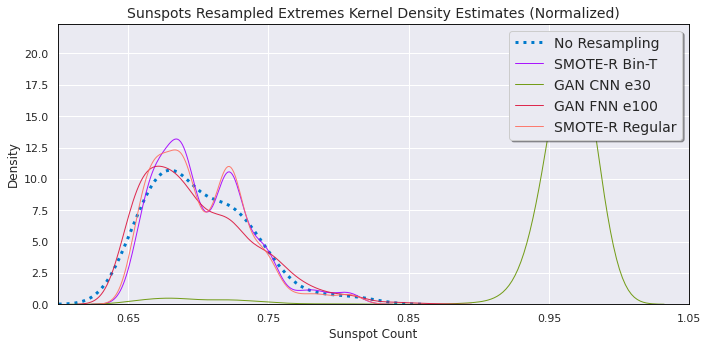

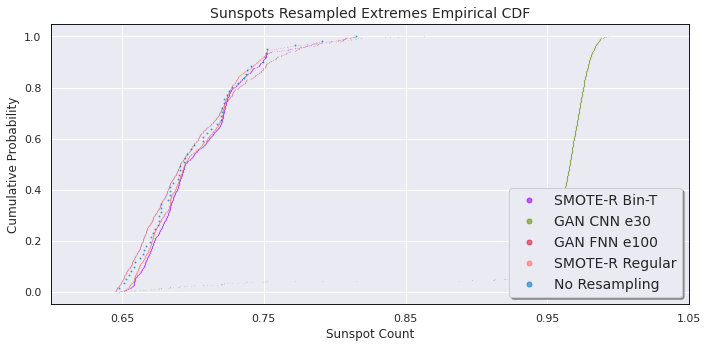

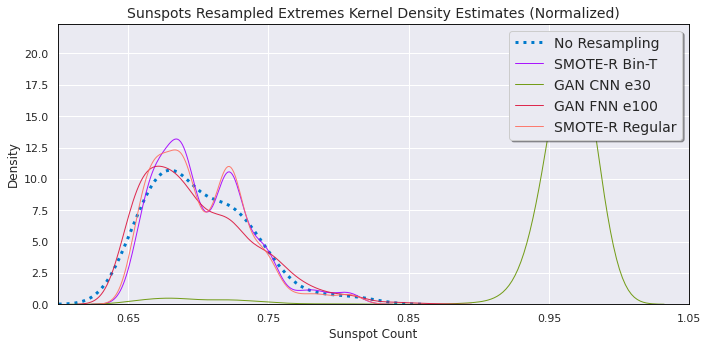

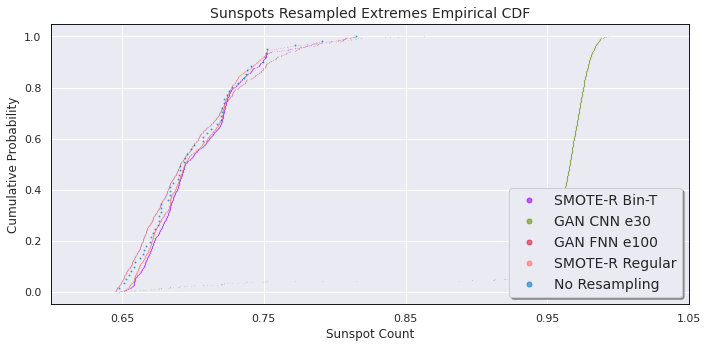

In [19]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)
step_out = 0

#compare KDE, CDF
for f in FORECASTERS:
    pu.PlotKDECompare(Y_train, BEST_RESULTS[f]['resampling_results'], RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, step_out, N_STEPS_IN*N_FVARS, EXTREMES_THRESHOLD, TVAR, DATA_NAME, f)    
    pu.PlotCDFCompare(Y_train, BEST_RESULTS[f]['resampling_results'], RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, step_out, N_STEPS_IN*N_FVARS, EXTREMES_THRESHOLD, TVAR, DATA_NAME, f)    

### Plot Eval Results Aggregated Over All Steps

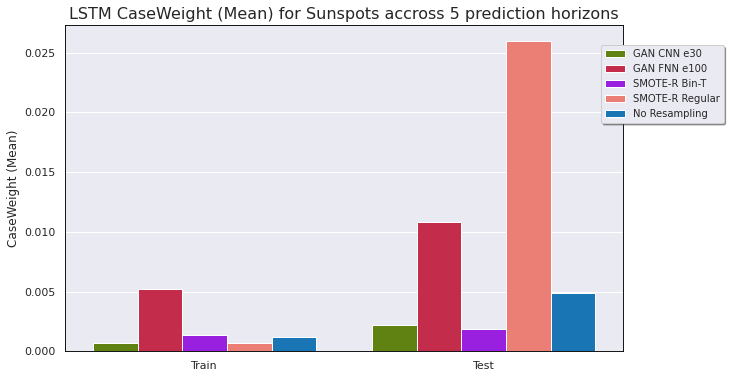

<Figure size 720x432 with 0 Axes>

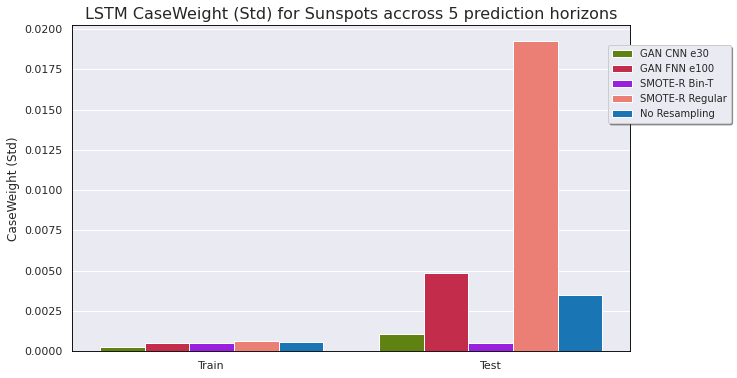

<Figure size 720x432 with 0 Axes>

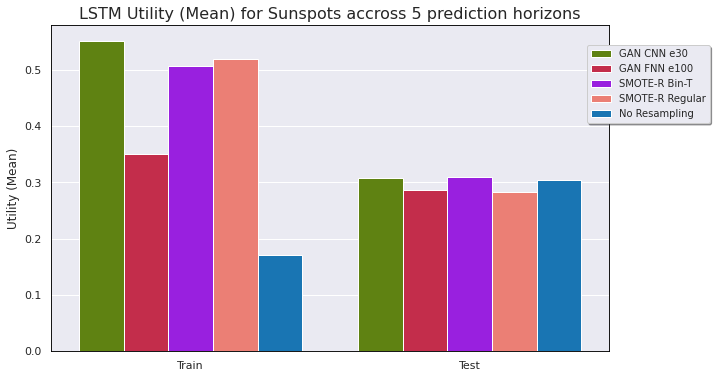

<Figure size 720x432 with 0 Axes>

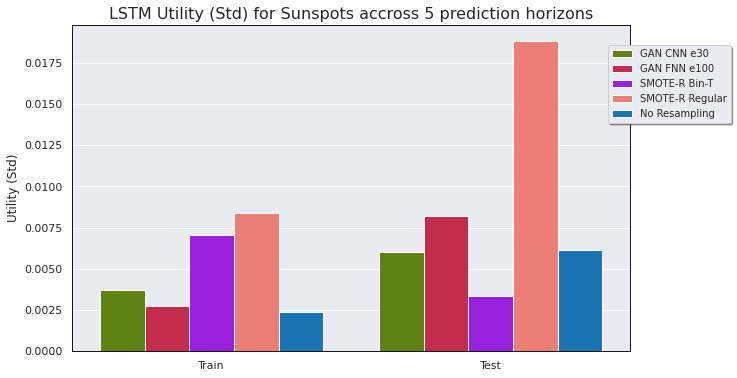

<Figure size 720x432 with 0 Axes>

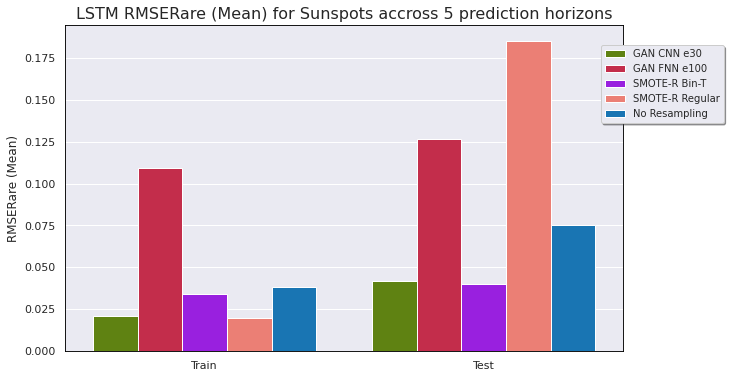

<Figure size 720x432 with 0 Axes>

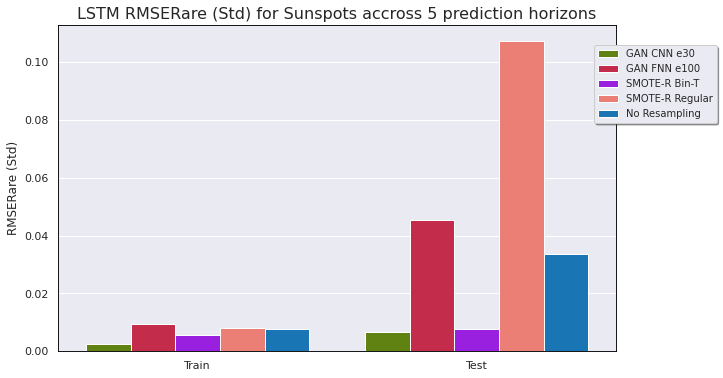

<Figure size 720x432 with 0 Axes>

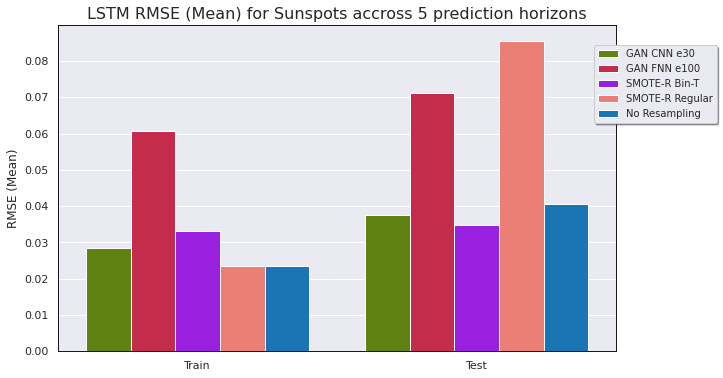

<Figure size 720x432 with 0 Axes>

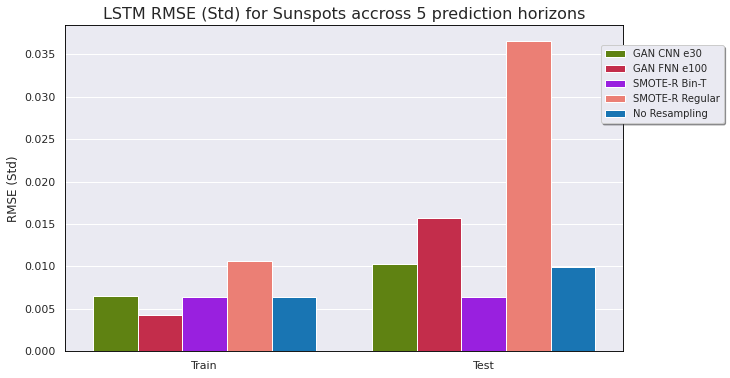

<Figure size 720x432 with 0 Axes>

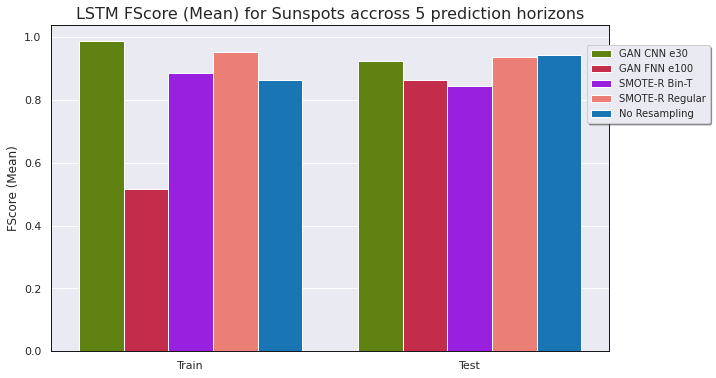

<Figure size 720x432 with 0 Axes>

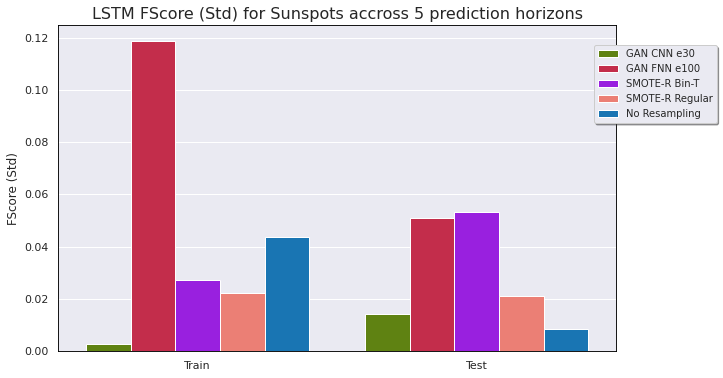

<Figure size 720x432 with 0 Axes>

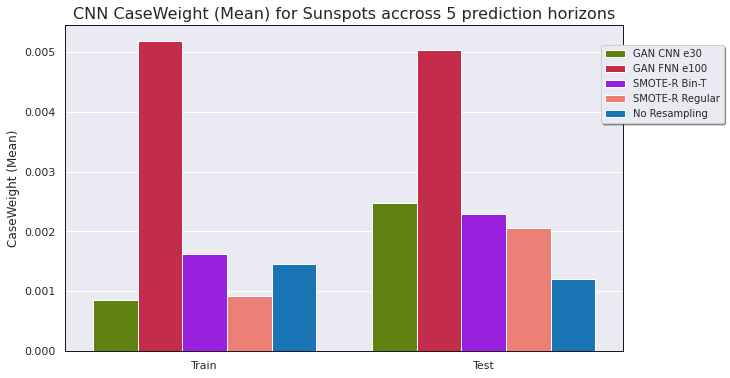

<Figure size 720x432 with 0 Axes>

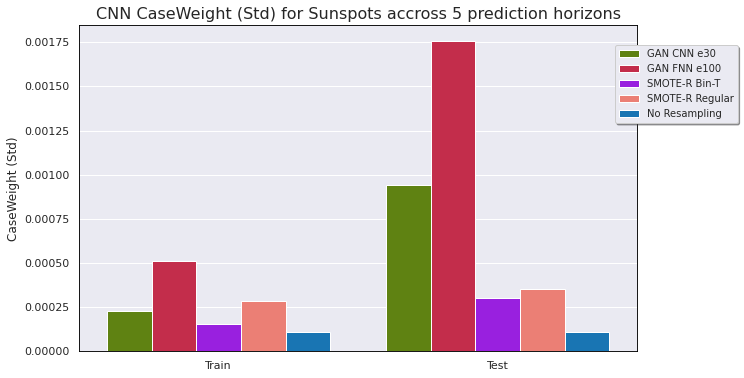

<Figure size 720x432 with 0 Axes>

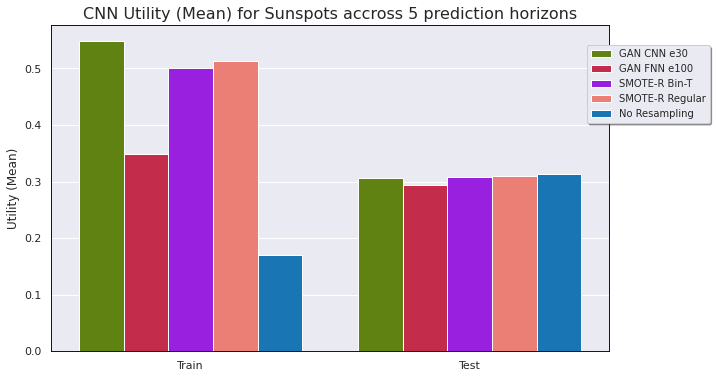

<Figure size 720x432 with 0 Axes>

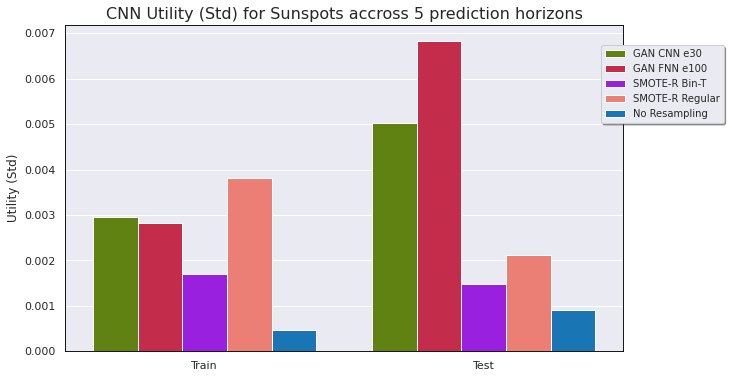

<Figure size 720x432 with 0 Axes>

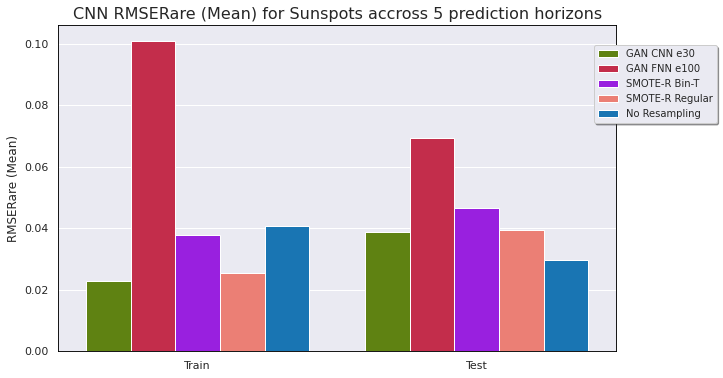

<Figure size 720x432 with 0 Axes>

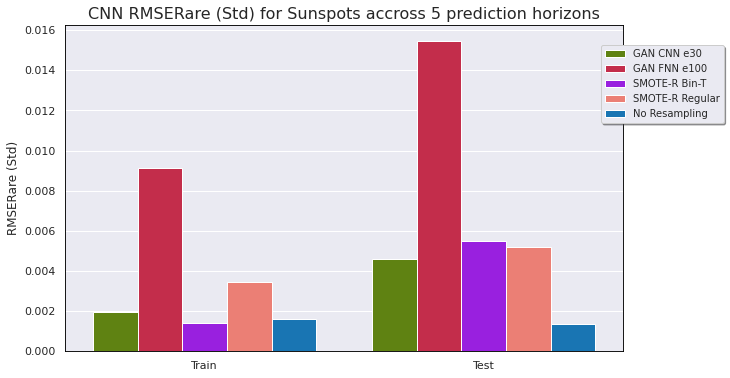

<Figure size 720x432 with 0 Axes>

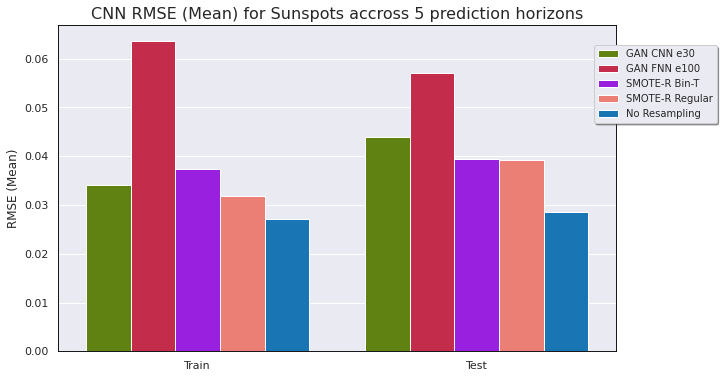

<Figure size 720x432 with 0 Axes>

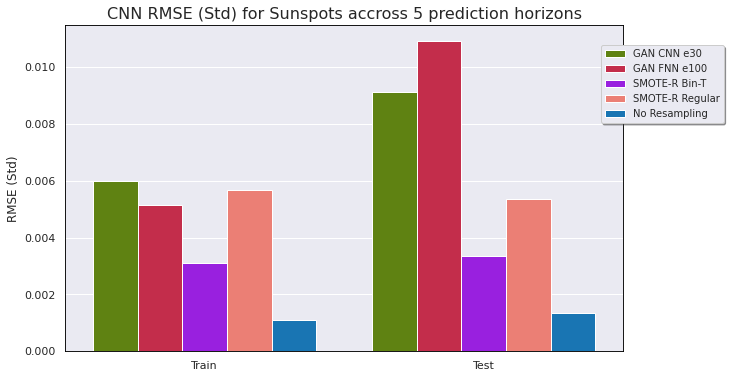

<Figure size 720x432 with 0 Axes>

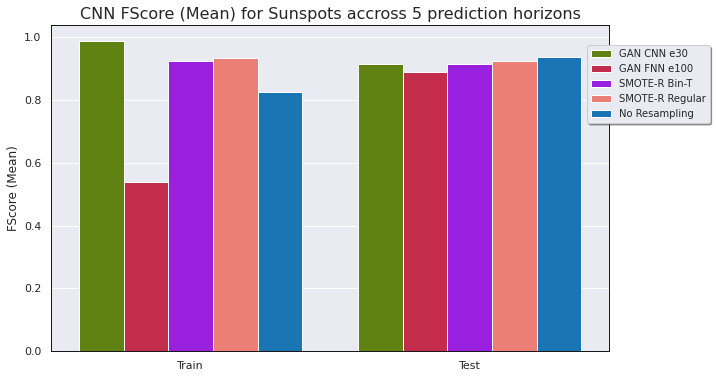

<Figure size 720x432 with 0 Axes>

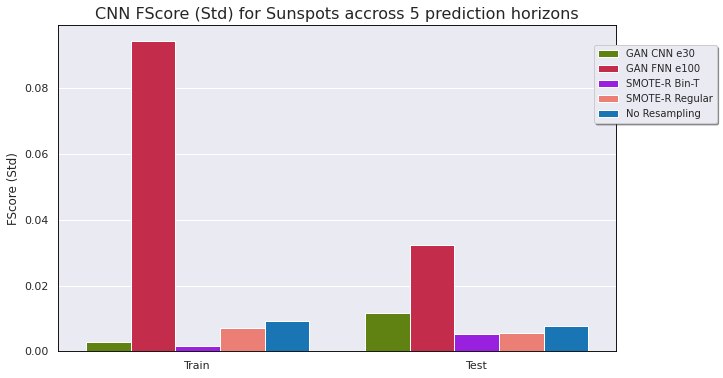

<Figure size 720x432 with 0 Axes>

In [20]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)


def calculate_mean(lst):
    return sum(lst) / len(lst)

#Just plot these metrics:
plot_metrics = ["CaseWeight", "Utility", "RMSERare", "RMSE", "FScore"]

ts = ["Train", "Test"] #one cluster for train, one for test results

#aggs options: 
aggs = ["Mean", "Std"]
## for "Mean" we get the mean of the eval metrics over all experiments and plot its average over time steps
## for "Std" we get the std of the eval metrics over all experiments and plot its average over time steps

#for f in FORECASTERS: EVALER[f], get best_cnn_gan, best_fnn_gan, best_bin from dict
#pass an argument to plotting function to specify f
for f in FORECASTERS:
    best_cnn_gan = BEST_RESULTS[f]['cnn_gan']
    best_fnn_gan = BEST_RESULTS[f]['fnn_gan']
    best_bin = BEST_RESULTS[f]['bin']
    for metric in plot_metrics:
        df_results = EVALERS[f].getExperimentSummaryDf(metric, True)
        df_results_train = EVALERS[f].getExperimentSummaryDf(metric, False)
        df_results[f"{metric}_Train_Mean"] = df_results_train[f"{metric}_Train_Mean"]
        df_results[f"{metric}_Train_Std"] = df_results_train[f"{metric}_Train_Std"]
        # Replace with the mean of the steps out lists
        df_results[f"{metric}_Train_Mean"] = df_results[f"{metric}_Train_Mean"].apply(calculate_mean)
        df_results[f"{metric}_Test_Mean"] = df_results[f"{metric}_Test_Mean"].apply(calculate_mean)
        df_results[f"{metric}_Train_Std"] = df_results[f"{metric}_Train_Std"].apply(calculate_mean)
        df_results[f"{metric}_Test_Std"] = df_results[f"{metric}_Test_Std"].apply(calculate_mean)
        for a in aggs:
            #remove any GAN_CNNs, GAN_FNNs, and SMOTER_bin strategies from the dataframe that aren't the best
            filtered_df = df_results[((df_results['Res'].str.contains('GAN_CNN|GAN_FNN')) & ((df_results['Res'] == best_cnn_gan) | (df_results['Res'] == best_fnn_gan))) | (~df_results['Res'].str.contains('GAN_CNN|GAN_FNN'))]
            filtered_df = filtered_df[((filtered_df['Res'].str.contains('SMOTER_bin')) & (filtered_df['Res'] == best_bin)) | (~filtered_df['Res'].str.contains('SMOTER_bin'))]
            '''
            filtered_df = df_results
            if best_cnn_gan:
                filtered_df = filtered_df[((filtered_df['Res'].str.contains('GAN_CNN')) & (filtered_df['Res'] == best_cnn_gan)) | (~filtered_df['Res'].str.contains('GAN_CNN'))]
            if best_fnn_gan:
                filtered_df = filtered_df[((filtered_df['Res'].str.contains('GAN_FNN')) & (filtered_df['Res'] == best_fnn_gan)) | (~filtered_df['Res'].str.contains('GAN_FNN'))]
            '''
            pu.PlotTrainTestBarResults(filtered_df, metric, a, DATA_NAME, N_STEPS_OUT, f)


### Plot Train and Test Eval Results Clustered By Steps Out

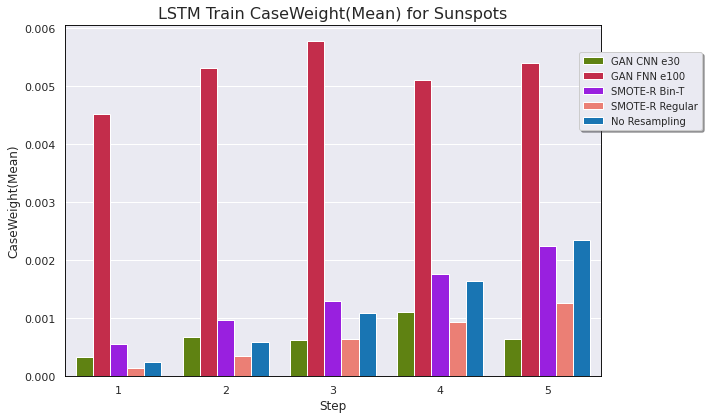

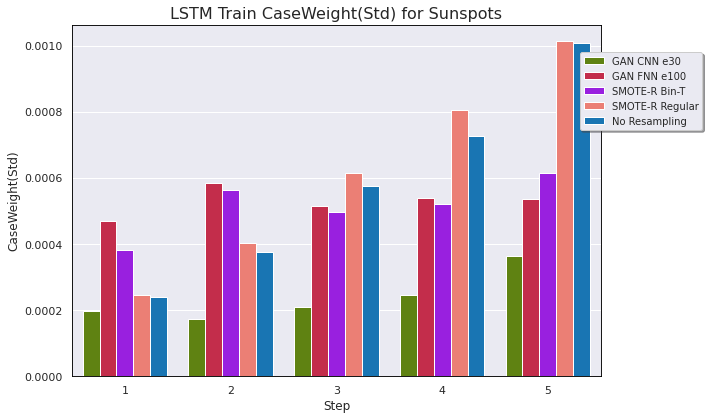

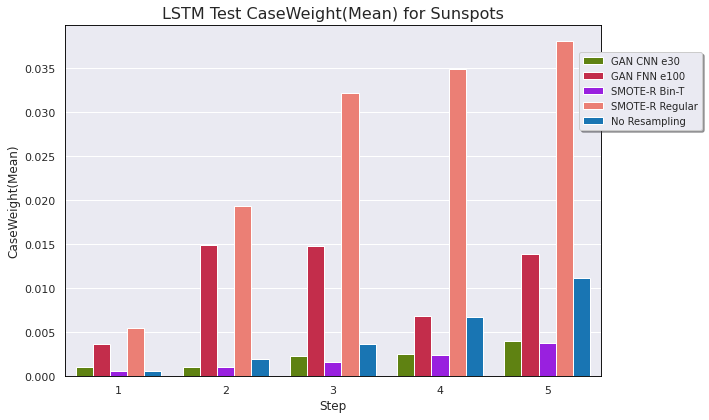

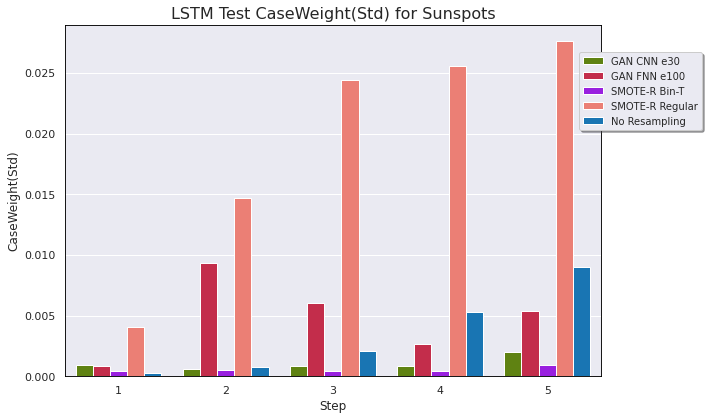

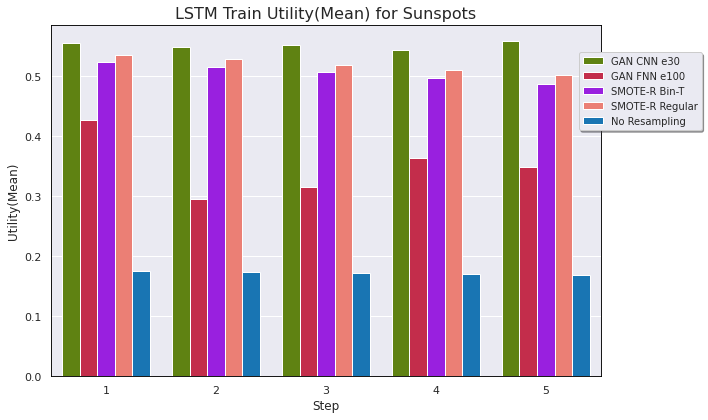

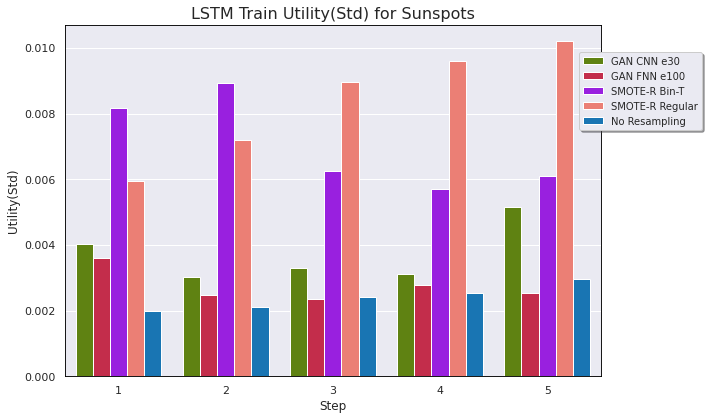

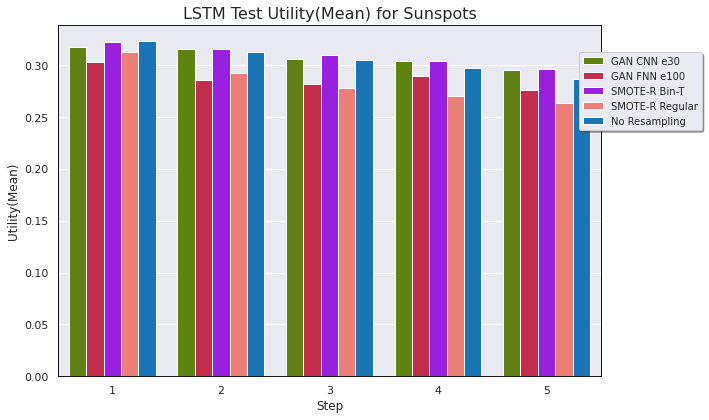

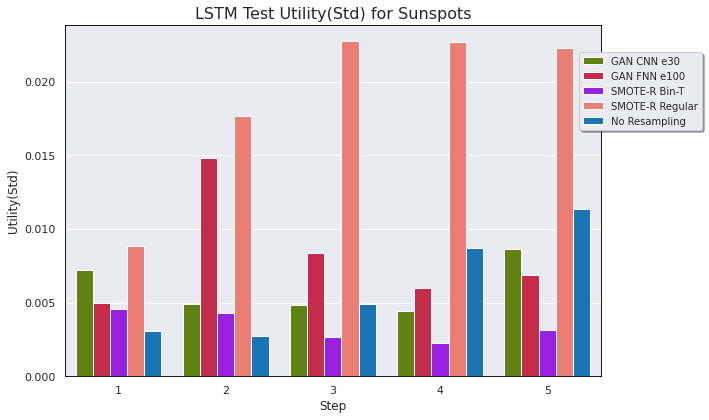

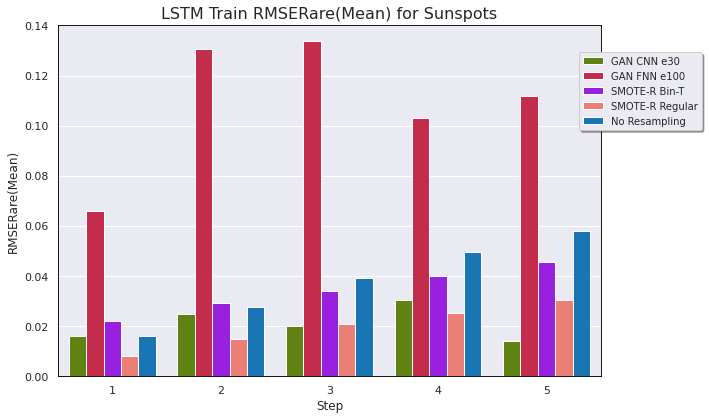

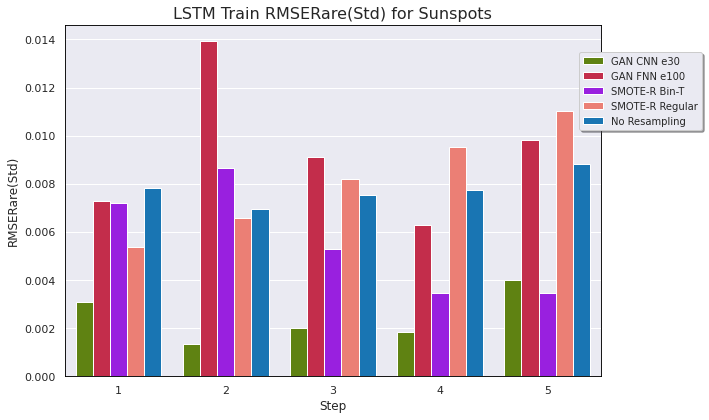

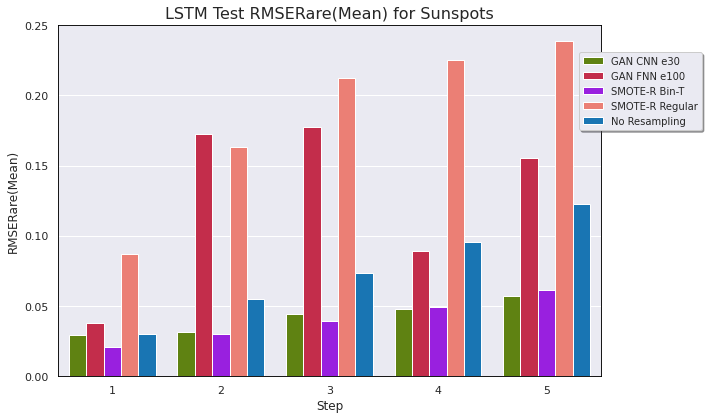

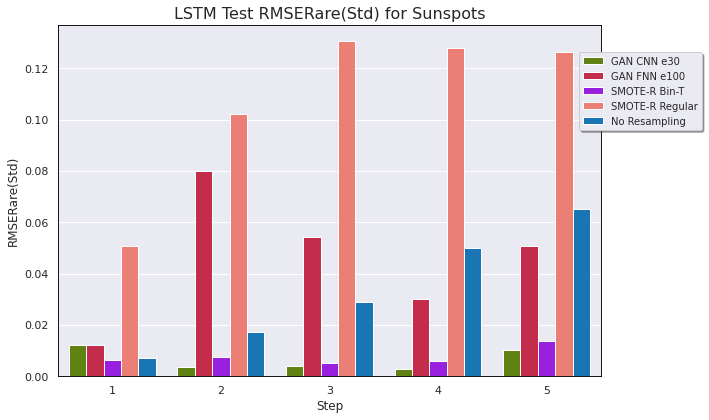

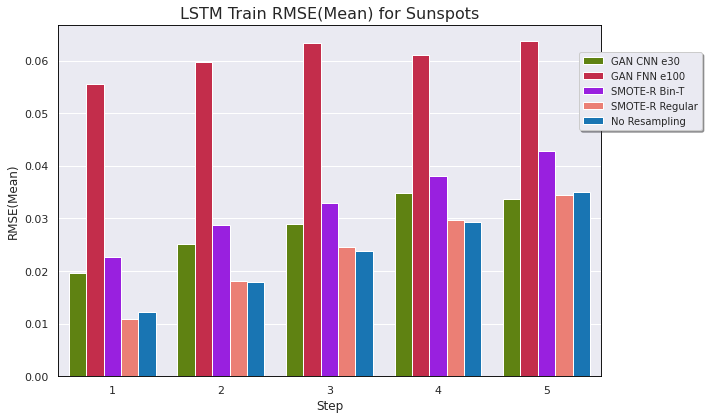

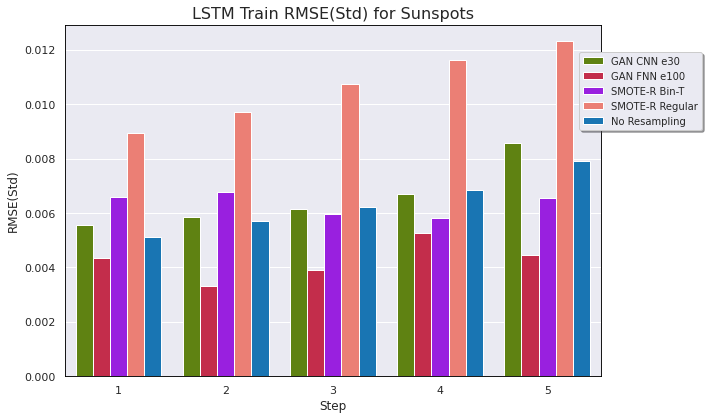

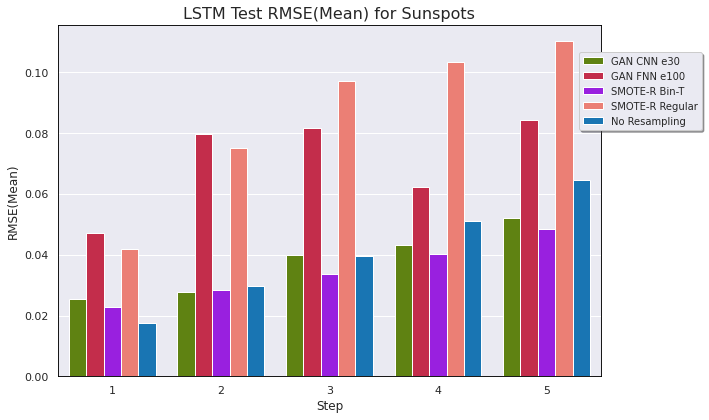

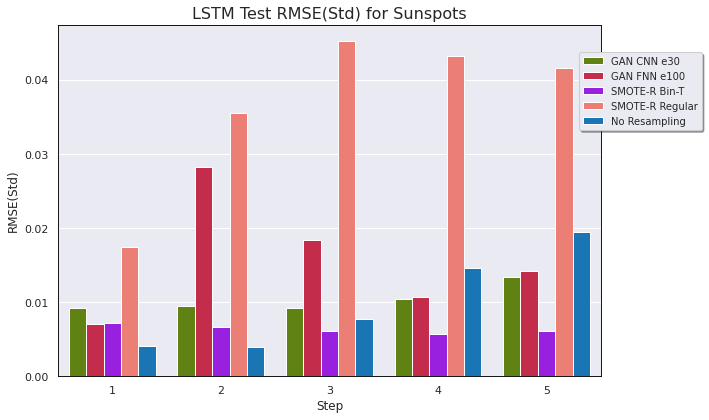

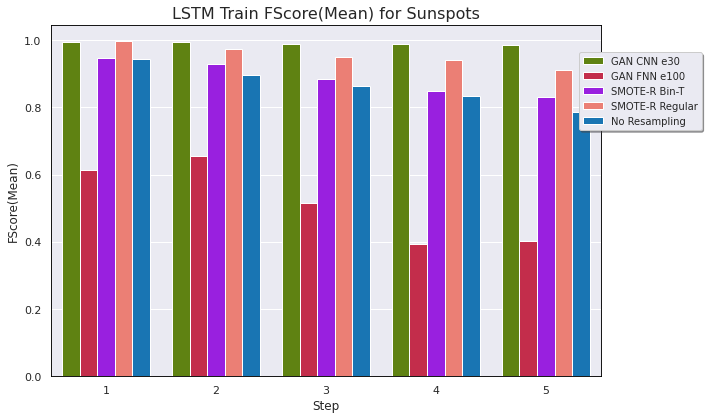

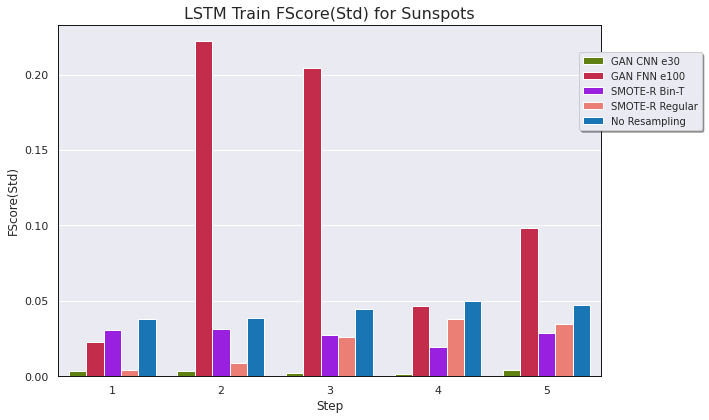

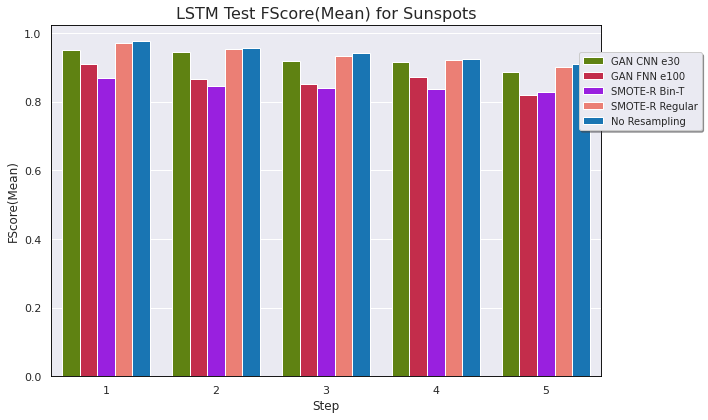

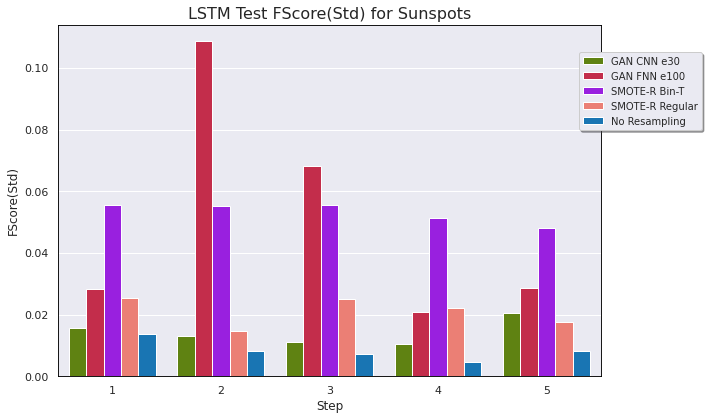

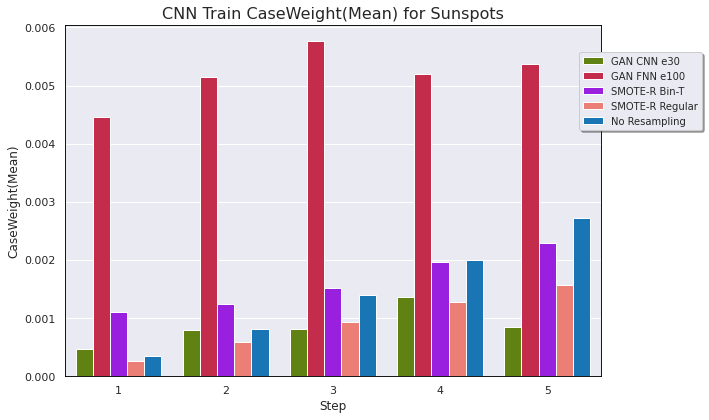

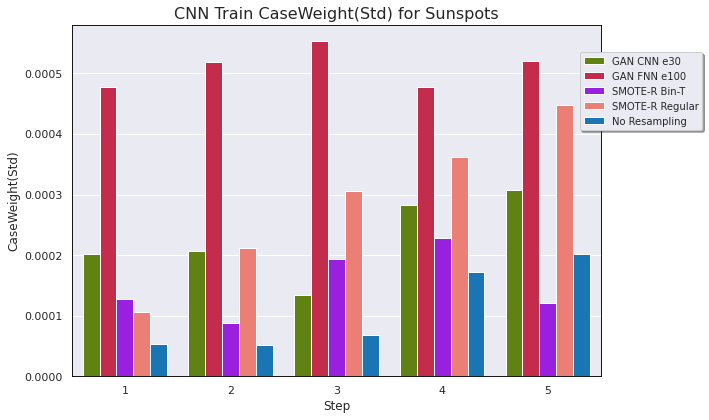

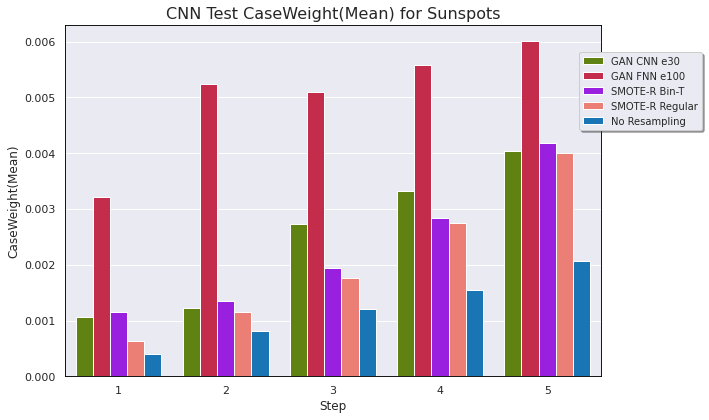

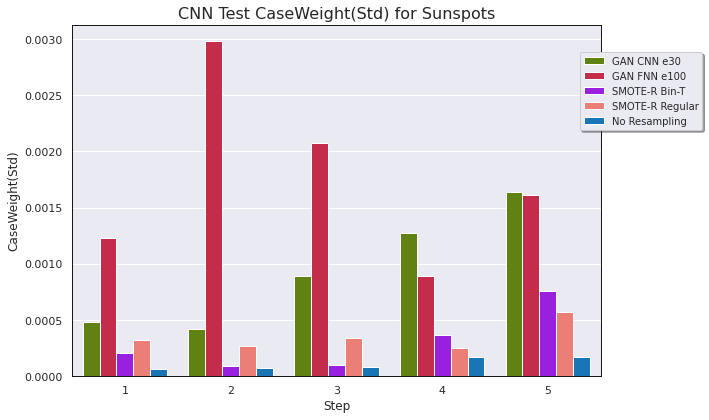

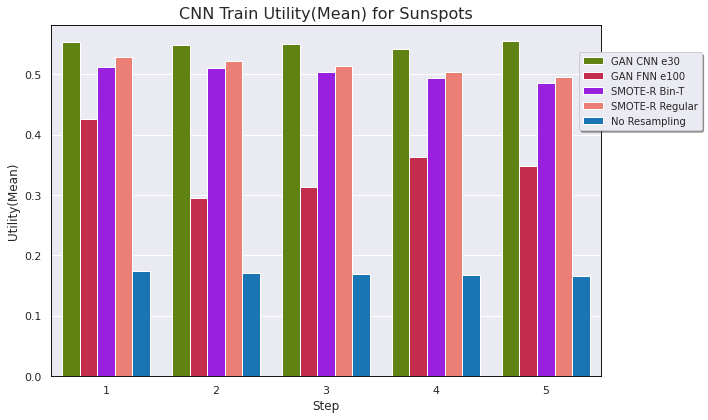

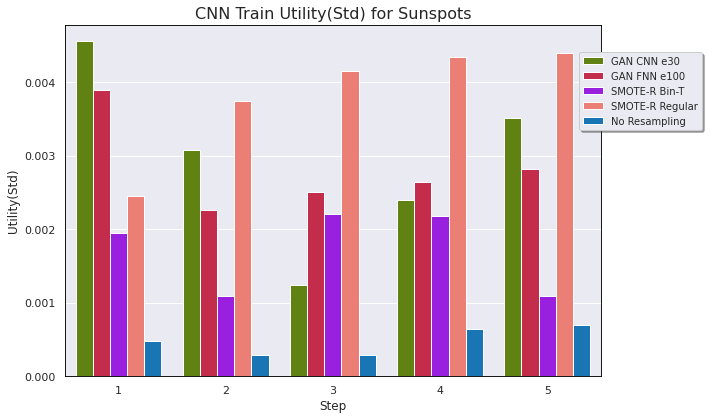

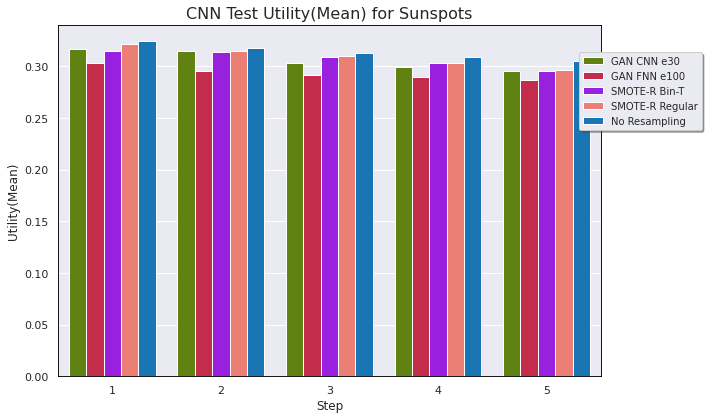

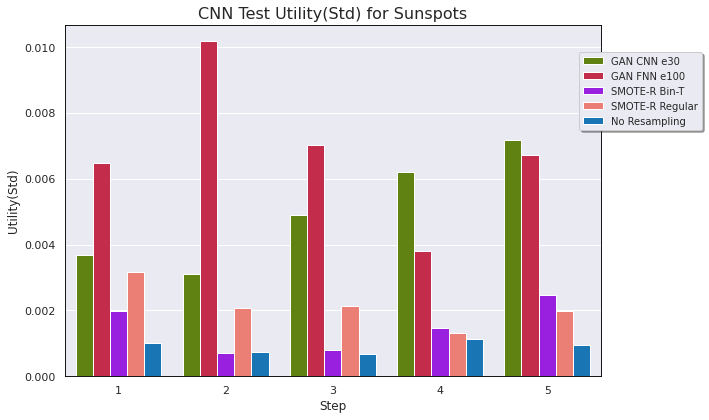

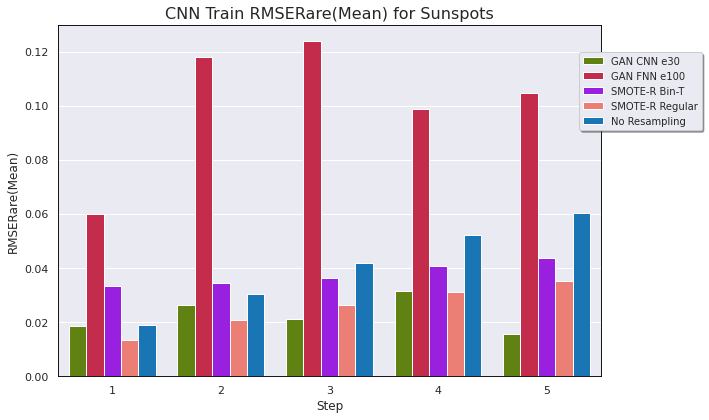

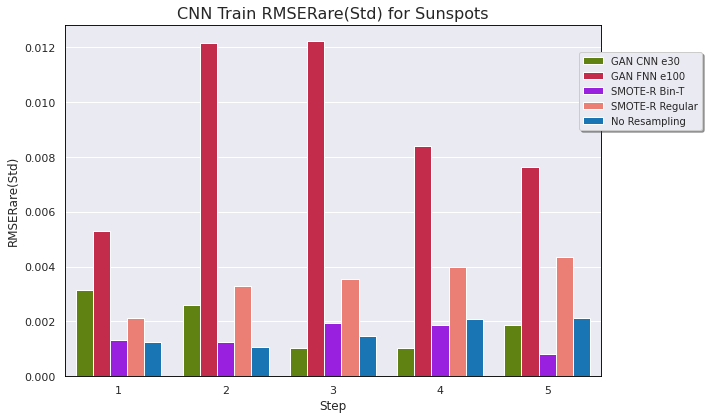

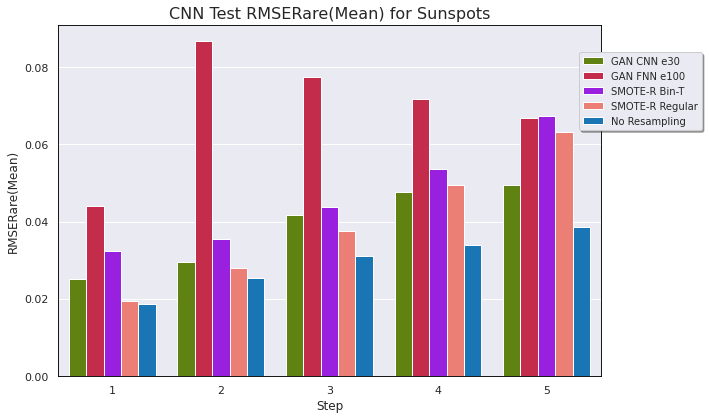

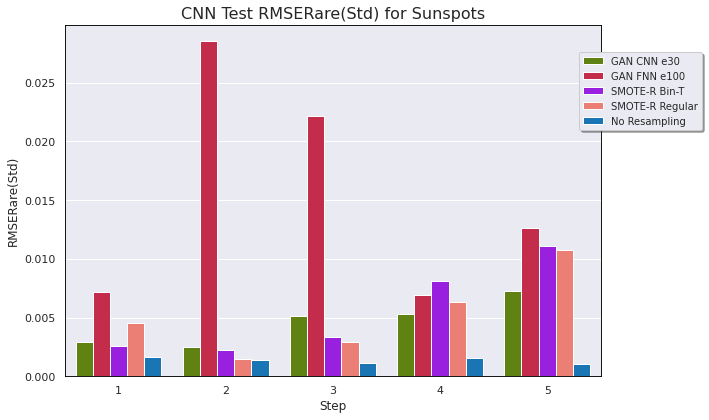

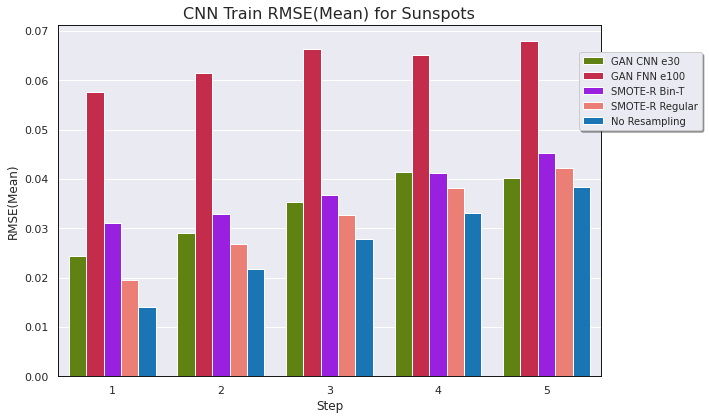

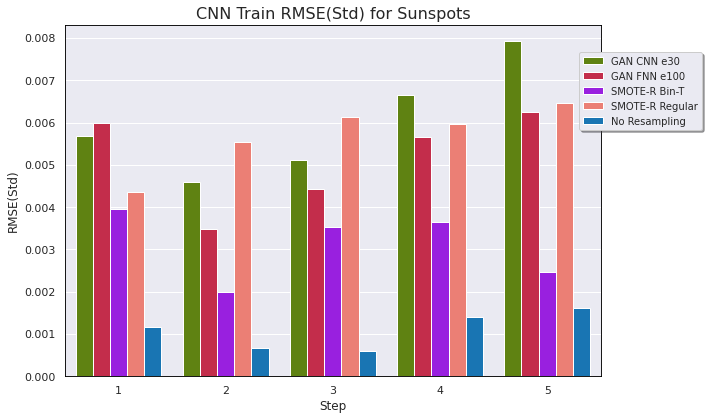

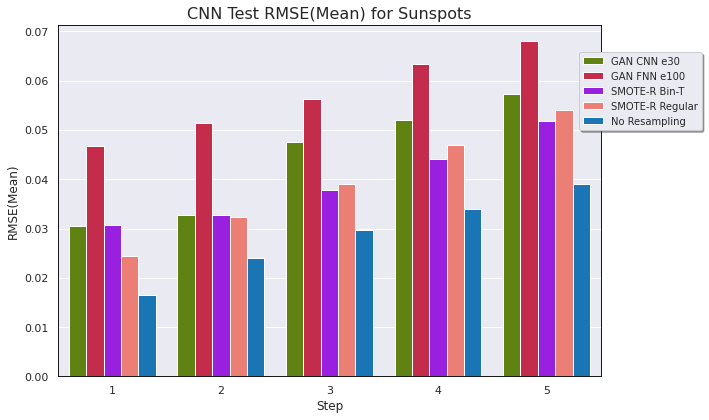

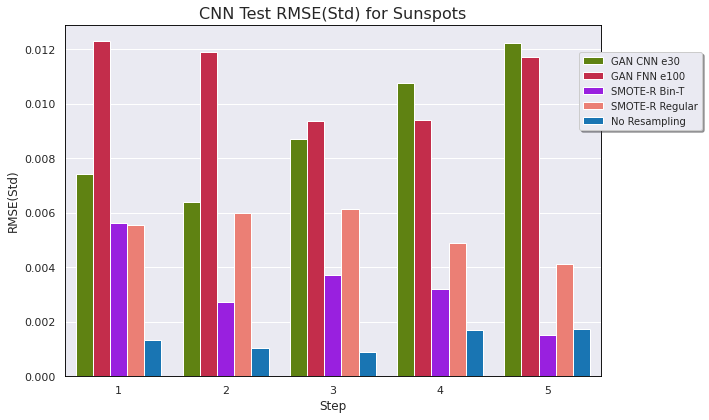

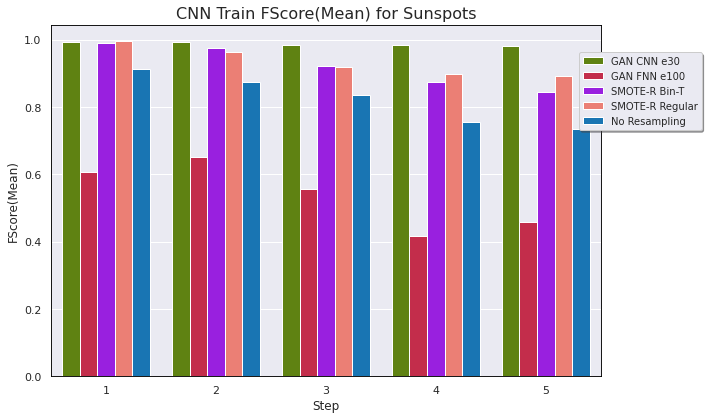

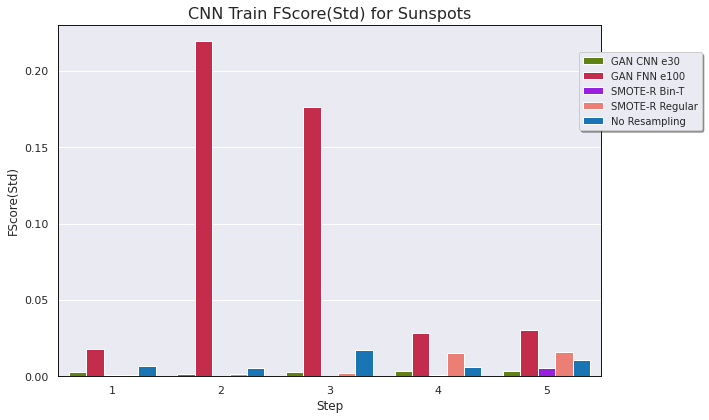

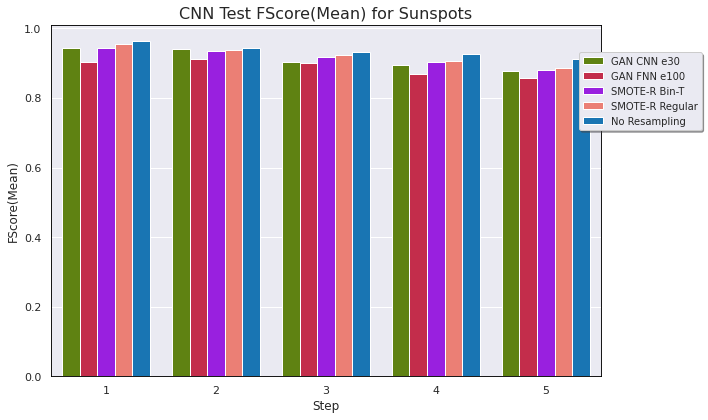

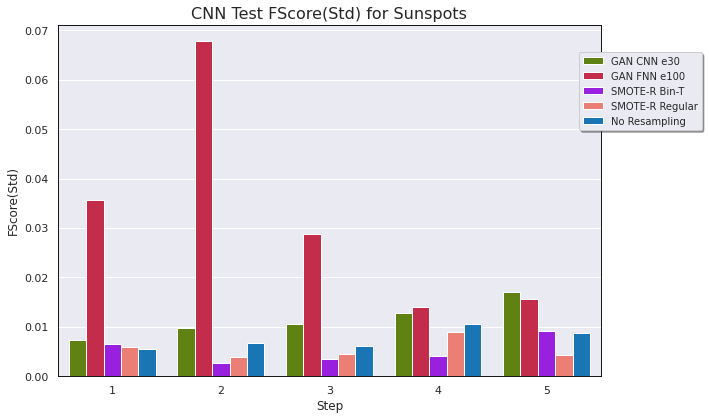

In [21]:
#Uncomment if you want to change stuff in plt_utils mid-session
#import plt_utils as pu
#importlib.reload(pu)
#Need to uncomment this is you're saving figures:
#pu.set_save_figs(True, RECORDER.figures_path)



plot_metrics = ["CaseWeight", "Utility", "RMSERare", "RMSE", "FScore"]
ts = ["Train", "Test"]
aggs = ["Mean", "Std"]
#either plot mean or std of the experiments
for f in FORECASTERS:
    best_cnn_gan = BEST_RESULTS[f]['cnn_gan']
    best_fnn_gan = BEST_RESULTS[f]['fnn_gan']
    best_bin = BEST_RESULTS[f]['bin']
    for metric in plot_metrics:
        for t in ts:
            tb = True if t == "Test" else False
            df_results = EVALERS[f].getExperimentSummaryDf(metric, tb)
            for a in aggs:
                #filter out all GAN_CNNs, GAN_FNNs or SMOTER_bins that aren't the best
                filtered_df = df_results[((df_results['Res'].str.contains('GAN_CNN|GAN_FNN')) & ((df_results['Res'] == best_cnn_gan) | (df_results['Res'] == best_fnn_gan))) | (~df_results['Res'].str.contains('GAN_CNN|GAN_FNN'))]
                filtered_df = filtered_df[((filtered_df['Res'].str.contains('SMOTER_bin')) & (filtered_df['Res'] == best_bin)) | (~filtered_df['Res'].str.contains('SMOTER_bin'))]
                pu.PlotStepBarResults(filtered_df, metric, a, t, DATA_NAME, N_STEPS_OUT, f)